In [1]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.9 MB/s eta 0:00:00


In [2]:
# Importamos los módulos de Python que utilizaremos
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn import linear_model
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Caso de uso

Datos de ventas anonimizados.

* https://www.kaggle.com/aswathrao/demand-forecasting

In [4]:
# leemos los datos
df = pd.read_csv("sample_data/train_0irEZ2H.csv")

## Análisis exploratorio

Ejercicio 1: obtener las dimensiones de la tabla.

In [ ]:
# Respuesta

df.shape

(150150, 9)

Vemos que tenemos unas dimensiones más que aceptables para abordar el problema.

Ejercicio 2: mostrar la cabecera de la tabla con 20 filas.

In [ ]:
# Respuesta

df.head(20)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
5,9,17/01/11,8091,219009,227.2875,227.2875,0,0,18
6,10,17/01/11,8091,219029,327.0375,327.0375,0,0,47
7,13,17/01/11,8091,223245,210.9000,210.9000,0,0,50
8,14,17/01/11,8091,223153,190.2375,234.4125,1,1,82
9,17,17/01/11,8095,216418,99.0375,99.0375,0,0,99


En la fuente desde la que se descargan los datos no aparece documentado el significado de cada columna. Sin embargo, es más o menos fácil entender qué es cada cosa:
* record_ID: identificador único de cada fila.
* week: semana en la que se realizó la venta.
* store_id: identificador de la tienda en la que se vendió el producto.
* sku_id: identificador del producto que se vendió.
* total_price: precio de venta del producto (no sabemos la moneda, pero tampoco hace falta...).
* base_price: precio base de venta del producto (se entiende que sobre este precio base puede haber variaciones, que es lo que se registra en "total_price", en función de descuentos, etc.; decir que tampoco conocemos la moneda).
* is_featured_sku: no está del todo claro. Podría significar si el producto cuenta con algún tipo de promoción especial, siendo 1 el caso positivo y 0 el contrario.
* is_display_sku: tampoco está claro. Puede significar si el producto está a la vista en la tienda, significando 1 que sí que está a la vista y 0 que no.
* units_sold: unidades vendidas. Esta será nuestra variable objetivo.

El significado de las columnas "is_featured_sku" y "is_display_sku" no está del todo claro. Para ganar algo de intuición sobre ellas, estaría bien si su valor tiene algún impacto en las ventas.

Ejercicio 3: calcula la media de las ventas para cada valor de "is_display_sku" y para cada valor de "is_featured_sku".

Respuesta (sigue en las siguientes celdas):
    
1. seleccionamos las variables que nos interesan ("is_display_sku" y "units_sold")
2. agrupamos por "is_display_sku"
3. calculamos la media de "units_sold"

In [ ]:
df[["is_display_sku", "units_sold"]].groupby(["is_display_sku"]).mean("units_sold")

,units_sold
is_display_sku,
0,43.114721
1,107.375050


In [ ]:
df[["is_display_sku", "sku_id", "units_sold"]].groupby(["is_display_sku", "sku_id"]).mean("units_sold")

units_sold
is_display_sku sku_id            
0              216233   46.144341
               216418   73.758626
               216419   57.257693
               216425   33.271110
               217217   19.168280
               217390   59.754732
               217777   21.881098
               219009   79.855518
               219029   38.923349
               219844   22.125933
               222087   54.754795
               222765   48.215288
               223153   39.267109
               223245   49.898440
               245338   24.543382
               245387   19.130000
               300021   38.942299
               300291   15.420020
               320485   27.821786
               327492   17.796748
               378934   22.627408
               398721   13.585560
               545621   14.370690
               546789   22.558322
               547934   18.896170
               600934   15.162197
               673209   18.563877
               679023   14.477117
1              216233   81.532609
               216418  124.577710
               216419  106.629700
               216425   64.280193
               217217   46.316883
               217390  130.293939
               217777   47.638158
               219009  317.807692
               219029  149.222826
               219844   54.139535
               222087  151.826039
               222765  130.840502
               223153  170.676010
               223245  181.025984
               245338   60.533433
               245387   50.226619
               300021   69.246774
               300291   29.072848
               320485   50.808081
               327492   56.642857
               378934   40.100503
               398721   38.349398
               545621   22.357143
               546789   32.489796
               547934   55.717391
               600934   61.102362
               673209   21.666667
               679023   22.935811

Hacemos lo propio para "is_featured_sku":

In [ ]:
df[["is_featured_sku", "units_sold"]].groupby(["is_featured_sku"]).mean("units_sold")

,units_sold
is_featured_sku,
0,45.062330
1,114.216216


Como vemos, en ambos casos las ventas aumentan sustancialmente cuando la variable vale 1.

Ejercicio 4: los valores de la columna "week" están almacenados como de tipo "str" (caracteres). Transformar a formato tipo fecha.

In [ ]:
# Respuesta.

df.week = pd.to_datetime(arg=df.week,
                         format="%d/%m/%y")

Ejercicio 5: obtener los valores perdidos de cada columna.

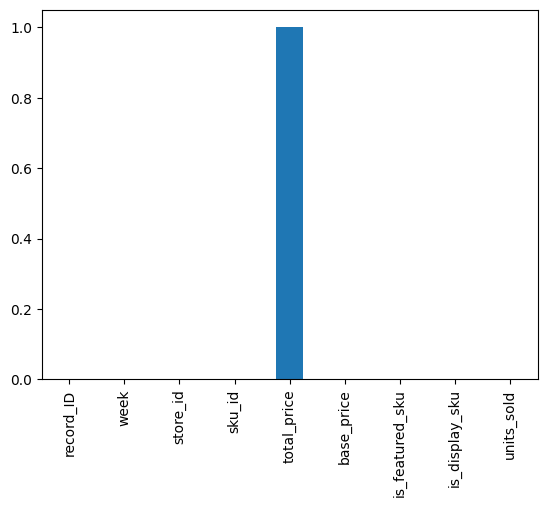

In [ ]:
# Respuesta
df.isna().sum().plot(kind="bar");

Solo la columna "total_price" tiene una fila con su valor ausente.

Ejercicio 6: la columna "record_ID" parece un identificador único para cada fila. Esto no nos interesa para el modelo de "Machine Learning". Asegúrate de que es identificador único y, entonces, elimina la columna.

In [ ]:
# Respuesta (sigue en la siguiente celda)

# Primero nos aseguramos de que "record_ID" toma tantos valores diferentes como filas tiene nuestra tabla de datos.
# Si el resultado es True, entonces es que es identificador único.
len(df) == len(df.record_ID.unique())

True

In [ ]:
# Como es identificador único, quitamos la columna con .drop():

df.drop(columns="record_ID", inplace=True)

Tenemos varias columnas para utilizar como variables independientes. Interesa saber de qué tipo es cada una.

Ejercicio 7: ¿cuáles de las variables son numéricas? ¿Cuáles categóricas? ¿Alguna escapa a esta clasificación? ¿Cuál y por qué?

Respuesta:

* Numéricas: "total_price" y "base_price"
* Categóricas: "store_id", "sku_id", "is_featured_sku" e "is_display_sku". Todas ellas están guardadas como números, pero está claro que pertenecen a categorías: "store_id" es realmente una tienda, "sku_id" un producto" y las otras dos hacen mención a distintas propiedades de los productos.
* Caso especial: "week". Nos marca la escala temporal.

Ejercicio 8: mostrar los histogramas y correlaciones entre las variables numéricas. Pensar en sus implicaciones.

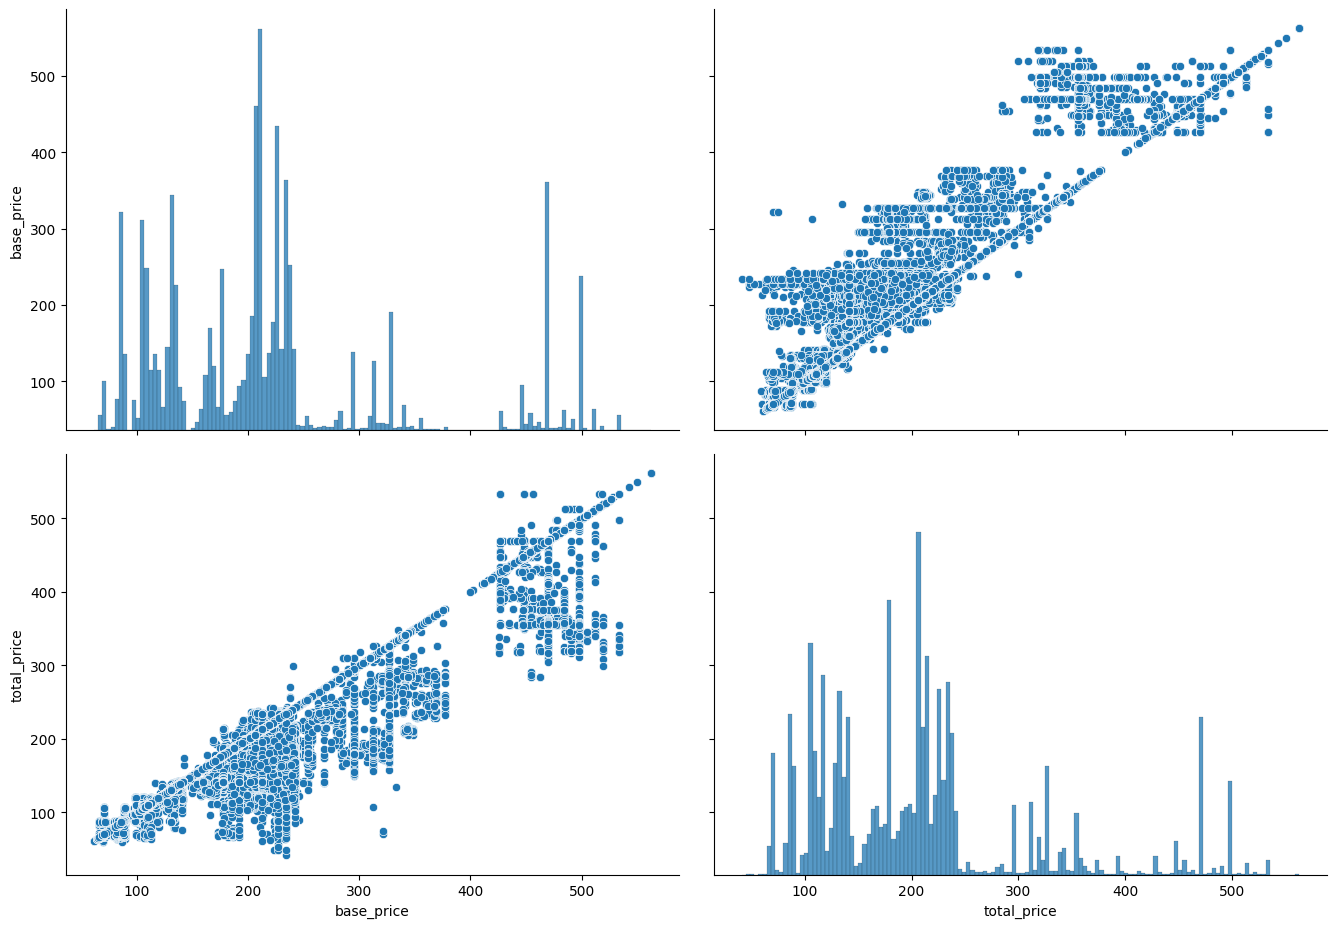

In [ ]:
# Respuesta

list_numerical_variables = ["base_price", "total_price"]
fig_pairplot = sns.pairplot(df[list_numerical_variables])
fig_pairplot.fig.set_size_inches(15, 10)

Destacar sobre todo que estas variables tienen una correlación altísima, así que es probable que hacer un PCA y quedarnos con una componente sea conveniente.

Ejercicio 9: en caso de haber encontrado algún valor perdido en el ejercicio 4, sustituirlo convenientemente. Antes de proceder, pensar en la estrategia a implementar. Por ejemplo, es importante:
* ¿Cuántas filas tienen valores perdidos? Si son muy pocas filas comparadas con el tamaño de la tabla, la estrategia (si tomamos la media, la mediana, un valor constante arbitrario, si eliminamos las filas...) tendrá poco impacto; en caso contrario, sí que será relevante.
* ¿La columna es numérica o categórica? Si es categórica, las estrategias de sustitución pueden ser la moda o un valor arbitrario, mientras que, si son numéricas, podemos tomar un valor constante arbitrario, la media, la mediana, etc.

Respuesta (sigue en la siguiente):

Solo la columna "total_price" tiene valores perdidos, la cual es numérica. Solo tiene una fila, así que la estrategia a implementar no es demasiado relevante. Por eso tomamos un valor arbitrario. Cogemos 200, que vemos que se trata de un valor típico. Como decimos, tomar otra estrategia (sustituir por otro valor típico, como puede ser cualquier cosa entre 100 y 500, tomar otro valor arbitrario, como puede ser 0, tomar la media, la mediana...) no debería tener apenas impacto. Elegimos un valor constante fijado y no algo como la media o la mediana, porque estos dos últimos requieren tomar antes división entre entranemiento y test para no cometer _leakage_.

In [ ]:
imp_constant = SimpleImputer(missing_values=np.nan,
                             strategy="constant",
                             fill_value=200)
array_total_price = imp_constant.fit_transform(np.array(df["total_price"]).reshape(-1, 1))
df["total_price"] = array_total_price

Ejercicio 10: toma las variables categóricas y calcula cuántas filas tienen cada uno de sus valores. Representa esto gráficamente de alguna forma. ¿Qué conclusiones sacas?

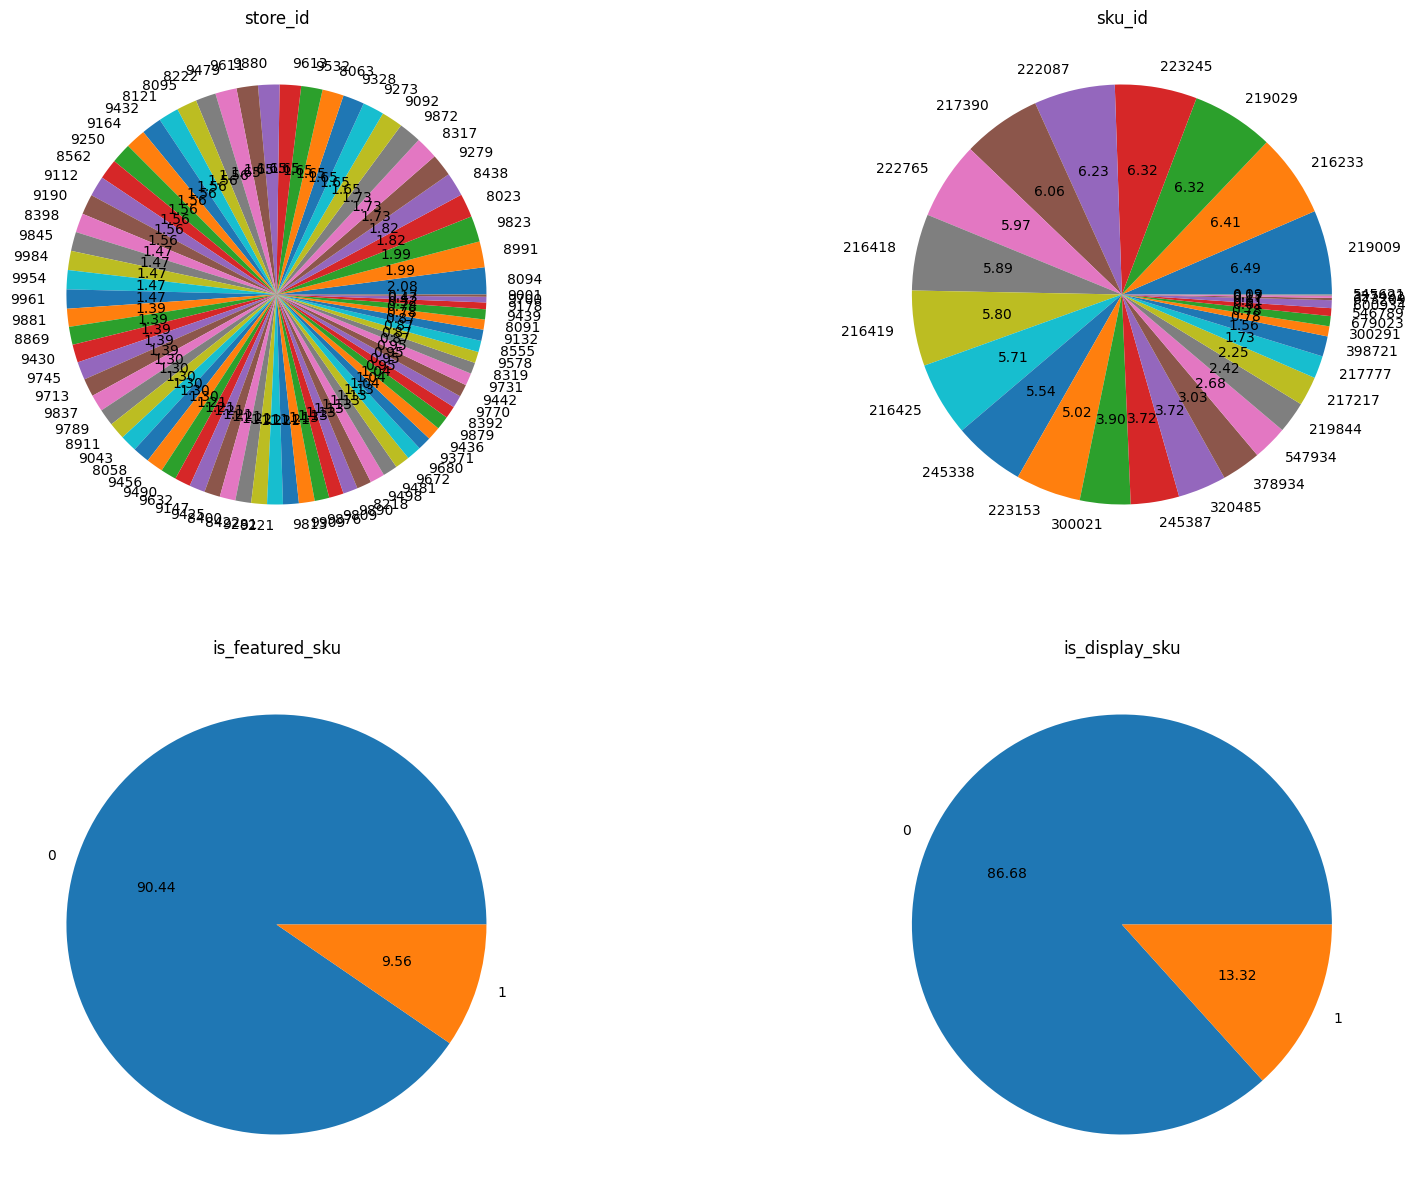

In [ ]:
# Respuesta (sigue en la siguiente celda):

# Tenemos cuatro variables categóricas, así que haremos cuatro gráficas.
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(20, 15)
# Calculamos aquí el número de filas que tiene cada valor de cada variable categórica y lo representamos
# en una gráfica tipo tarta.
df["store_id"].value_counts().rename("").plot.pie(autopct='%.2f', ax=axes[0, 0], title="store_id");
df["sku_id"].value_counts().rename("").plot.pie(autopct='%.2f', ax=axes[0, 1], title="sku_id");
df["is_featured_sku"].value_counts().rename("").plot.pie(autopct='%.2f', ax=axes[1, 0], title="is_featured_sku");
df["is_display_sku"].value_counts().rename("").plot.pie(autopct='%.2f', ax=axes[1, 1], title="is_display_sku");

Las variables "is_featured_sku" y "is_display_sku" tienen solo dos valores, como ya sabíamos. Si bien hay un claro desequilibrio entre ambos valores, el valor 1 no se puede decir que tenga una aparición marginal. Dicho esto, lo más razonable será dejar estas variables categóricas tal y como están. Además, ya hemos visto previamente que tienen impacto en las ventas.

Por su parte, las variable "store_id" y "sku_id" toman muchísimos valores. Esto hace pensar que una transformación tipo _one-hot encoding_ no será la mejor idea posible. Por otra parte, al tener tantísima variabilidad (sobre todo "store_id"), está por ver si aportan información.

Tenemos un problema de previsión de la demanda en el que tenemos como eje temporal la semana y contamos con datos de ventas para combinaciones de productos y tiendas.

Ejercicio 11: comprobar que la combinación de semana, producto y tienda es identificador único, es decir, que hay tantos valores únicos de "week" + "sku_id" + "store_id" como filas.

In [ ]:
# Respuesta

# Calculamos la variable booleana que compara el número de filas de la tabla (len(df))
# con el número de valores únicos de combinaciones entre "week", "store_id" y "sku_id".
# Notar que transformamos las tres variables a tipo carácter para poder concatenarlas.
len((df["week"].astype(dtype=str) + df["store_id"].astype(dtype=str) + df["sku_id"].astype(dtype=str)).unique()) == len(df)

True

Vemos que el resultado es True, así que confirmamos lo que nos preguntábamos.

Algo fundamental a la hora de hacer previsión de la demanda es visualizar previamente las curvas con las ventas en función del tiempo.

Ejercicio 12: escribir una función que coja como argumentos nuestra tabla de datos, el producto que queremos representar y la tienda en la que queremos estudiar las ventas y nos muestre la curva de ventas en función del tiempo. Una vez construida, mostrar alguna curva a modo de ejemplo.

In [ ]:
# Respuesta (sigue en las siguientes celdas)

# Escribimos la función:
def plot_sales(df, str_sku, str_store):
    """
    Esta función parte de un producto y una tienda y dibuja las ventas
    en función del tiempo.
    """
    plt.figure()
    plt.rcParams.update({'font.size': 22})

    srs_bool_filter = (df.sku_id == str_sku) & (df.store_id == str_store)
    ax = df.loc[srs_bool_filter, ["week", "units_sold"]].set_index(keys="week").plot(figsize=(30, 20))
    ax.set_title("Ventas para el producto " + str(str_sku) + " en la tienda " + str(str_store) + ".")
    plt.xticks(rotation=90)



<Figure size 640x480 with 0 Axes>

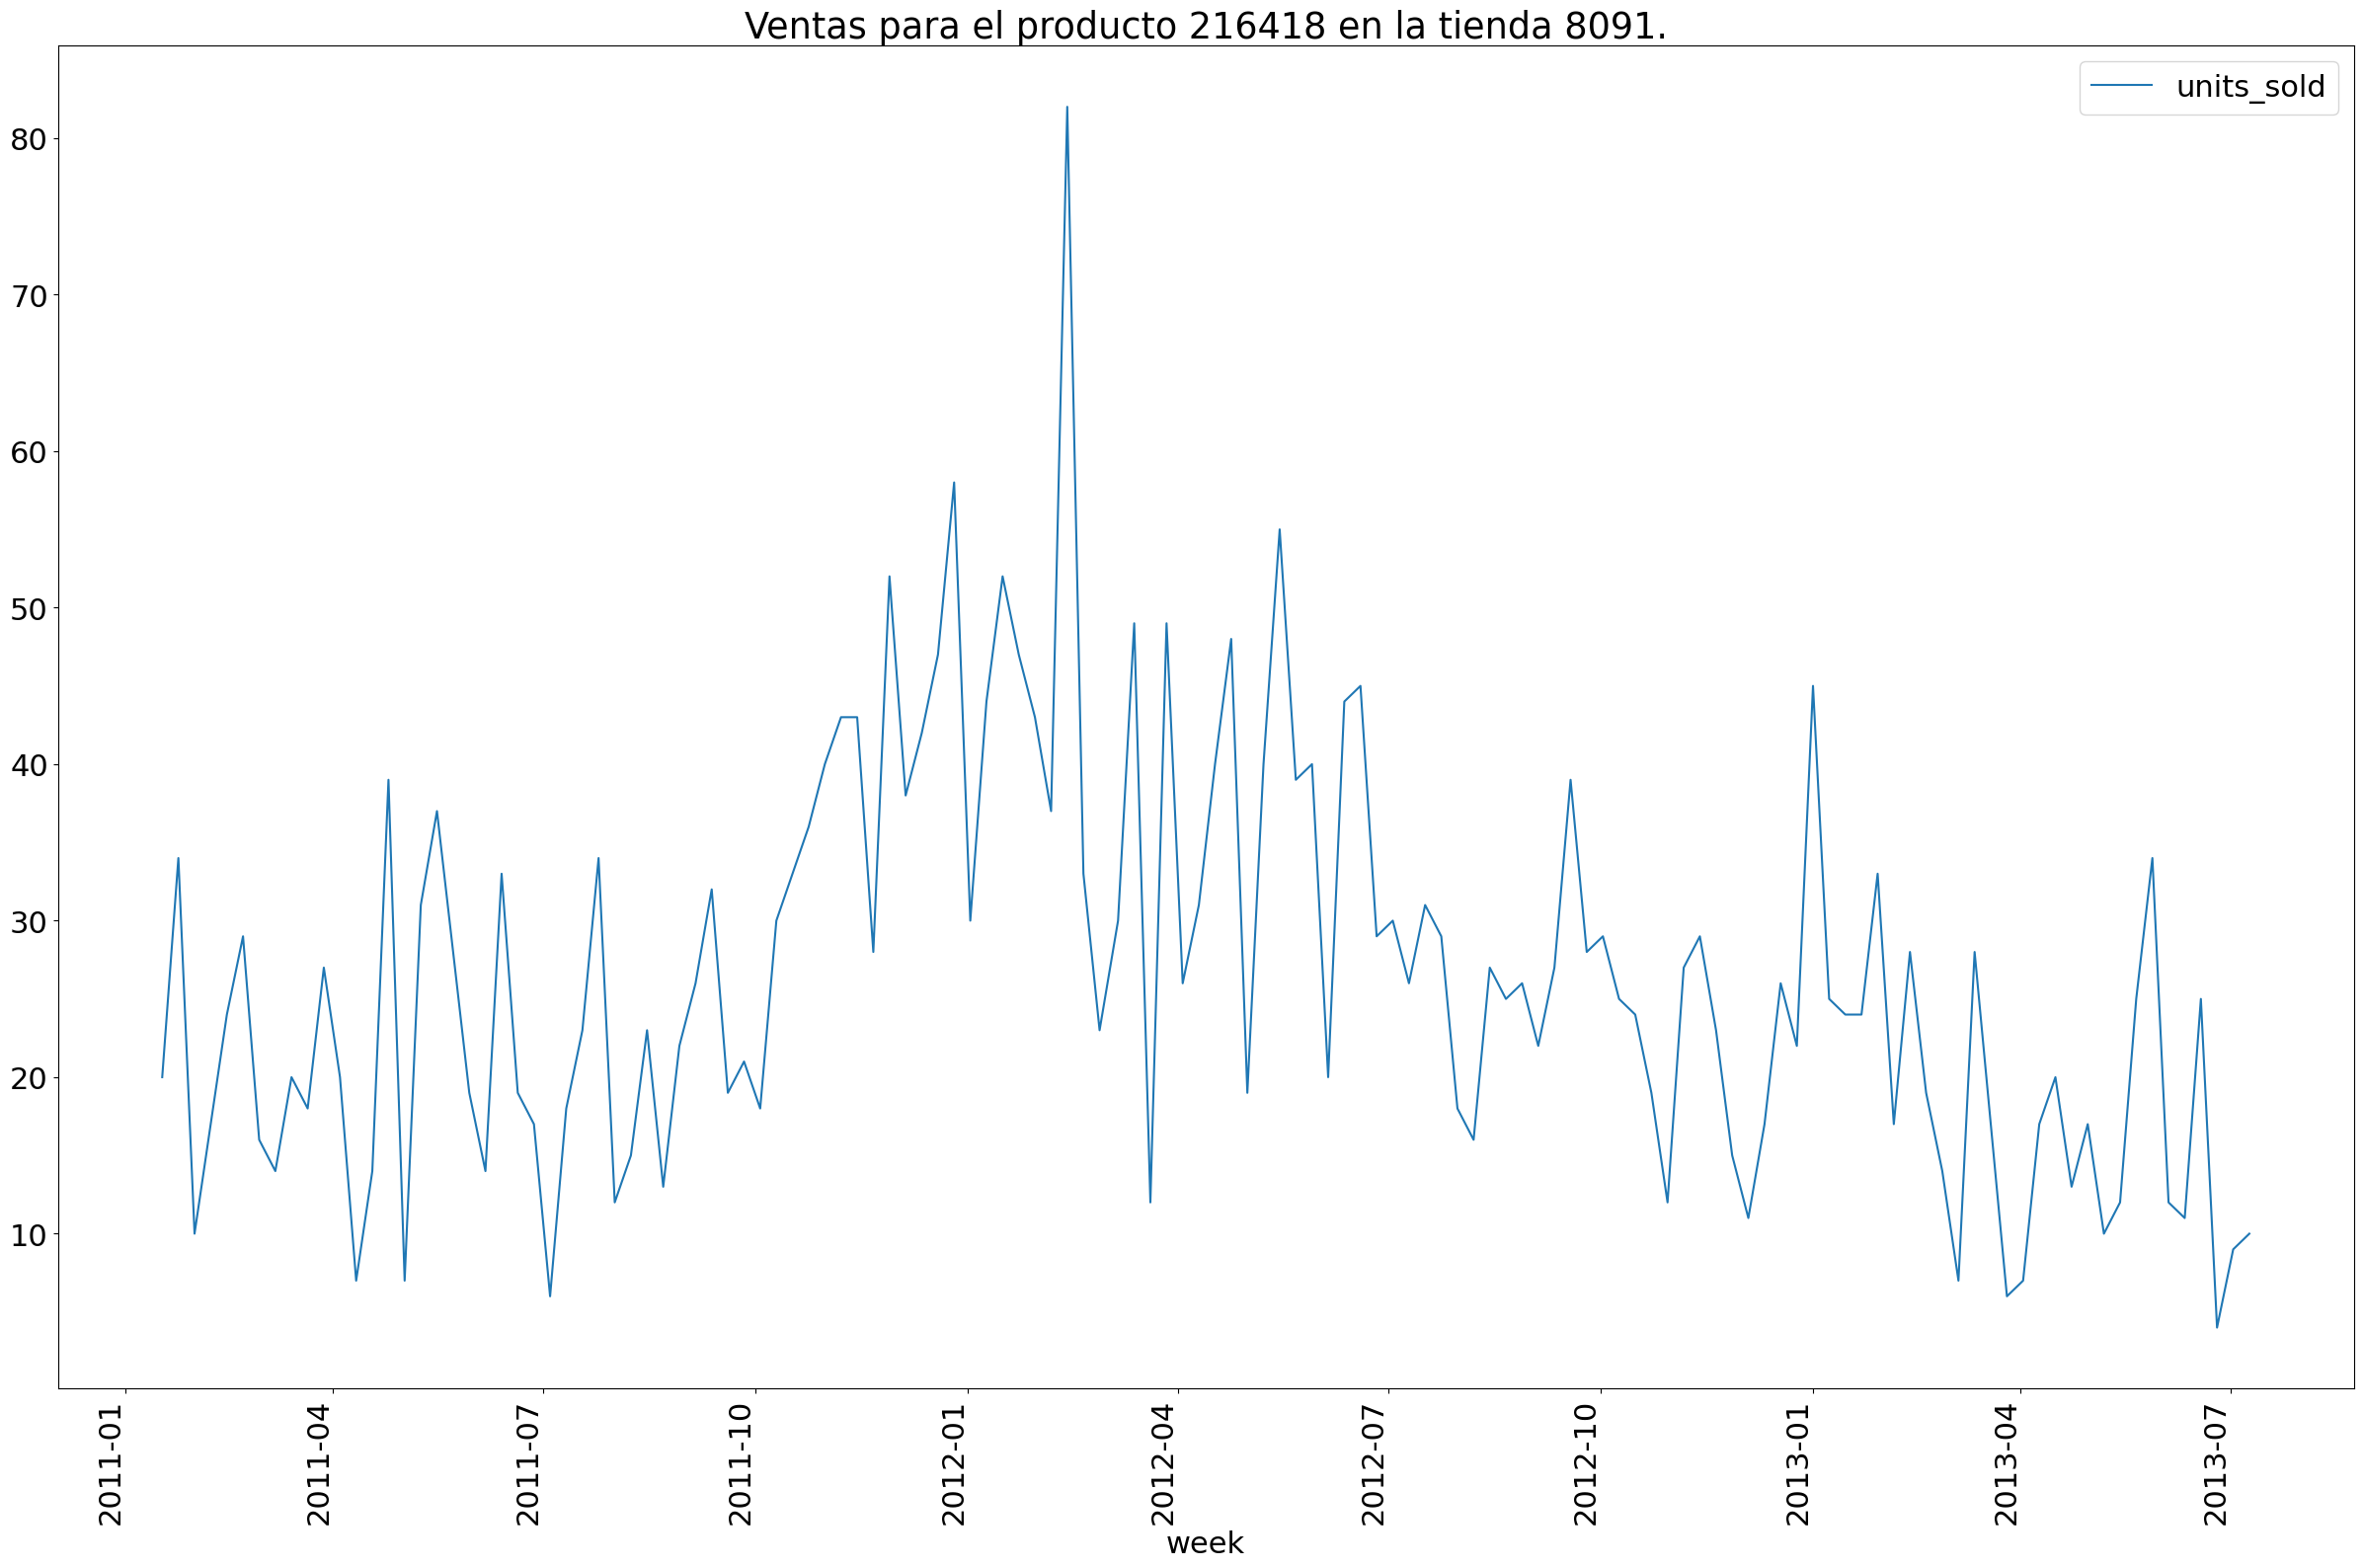

In [ ]:
# Mostramos algunos ejemplos:

list_sku_id = df.sku_id.unique().tolist()
list_store_id = df.store_id.unique().tolist()

plot_sales(df, list_sku_id[0], list_store_id[0])

<Figure size 640x480 with 0 Axes>

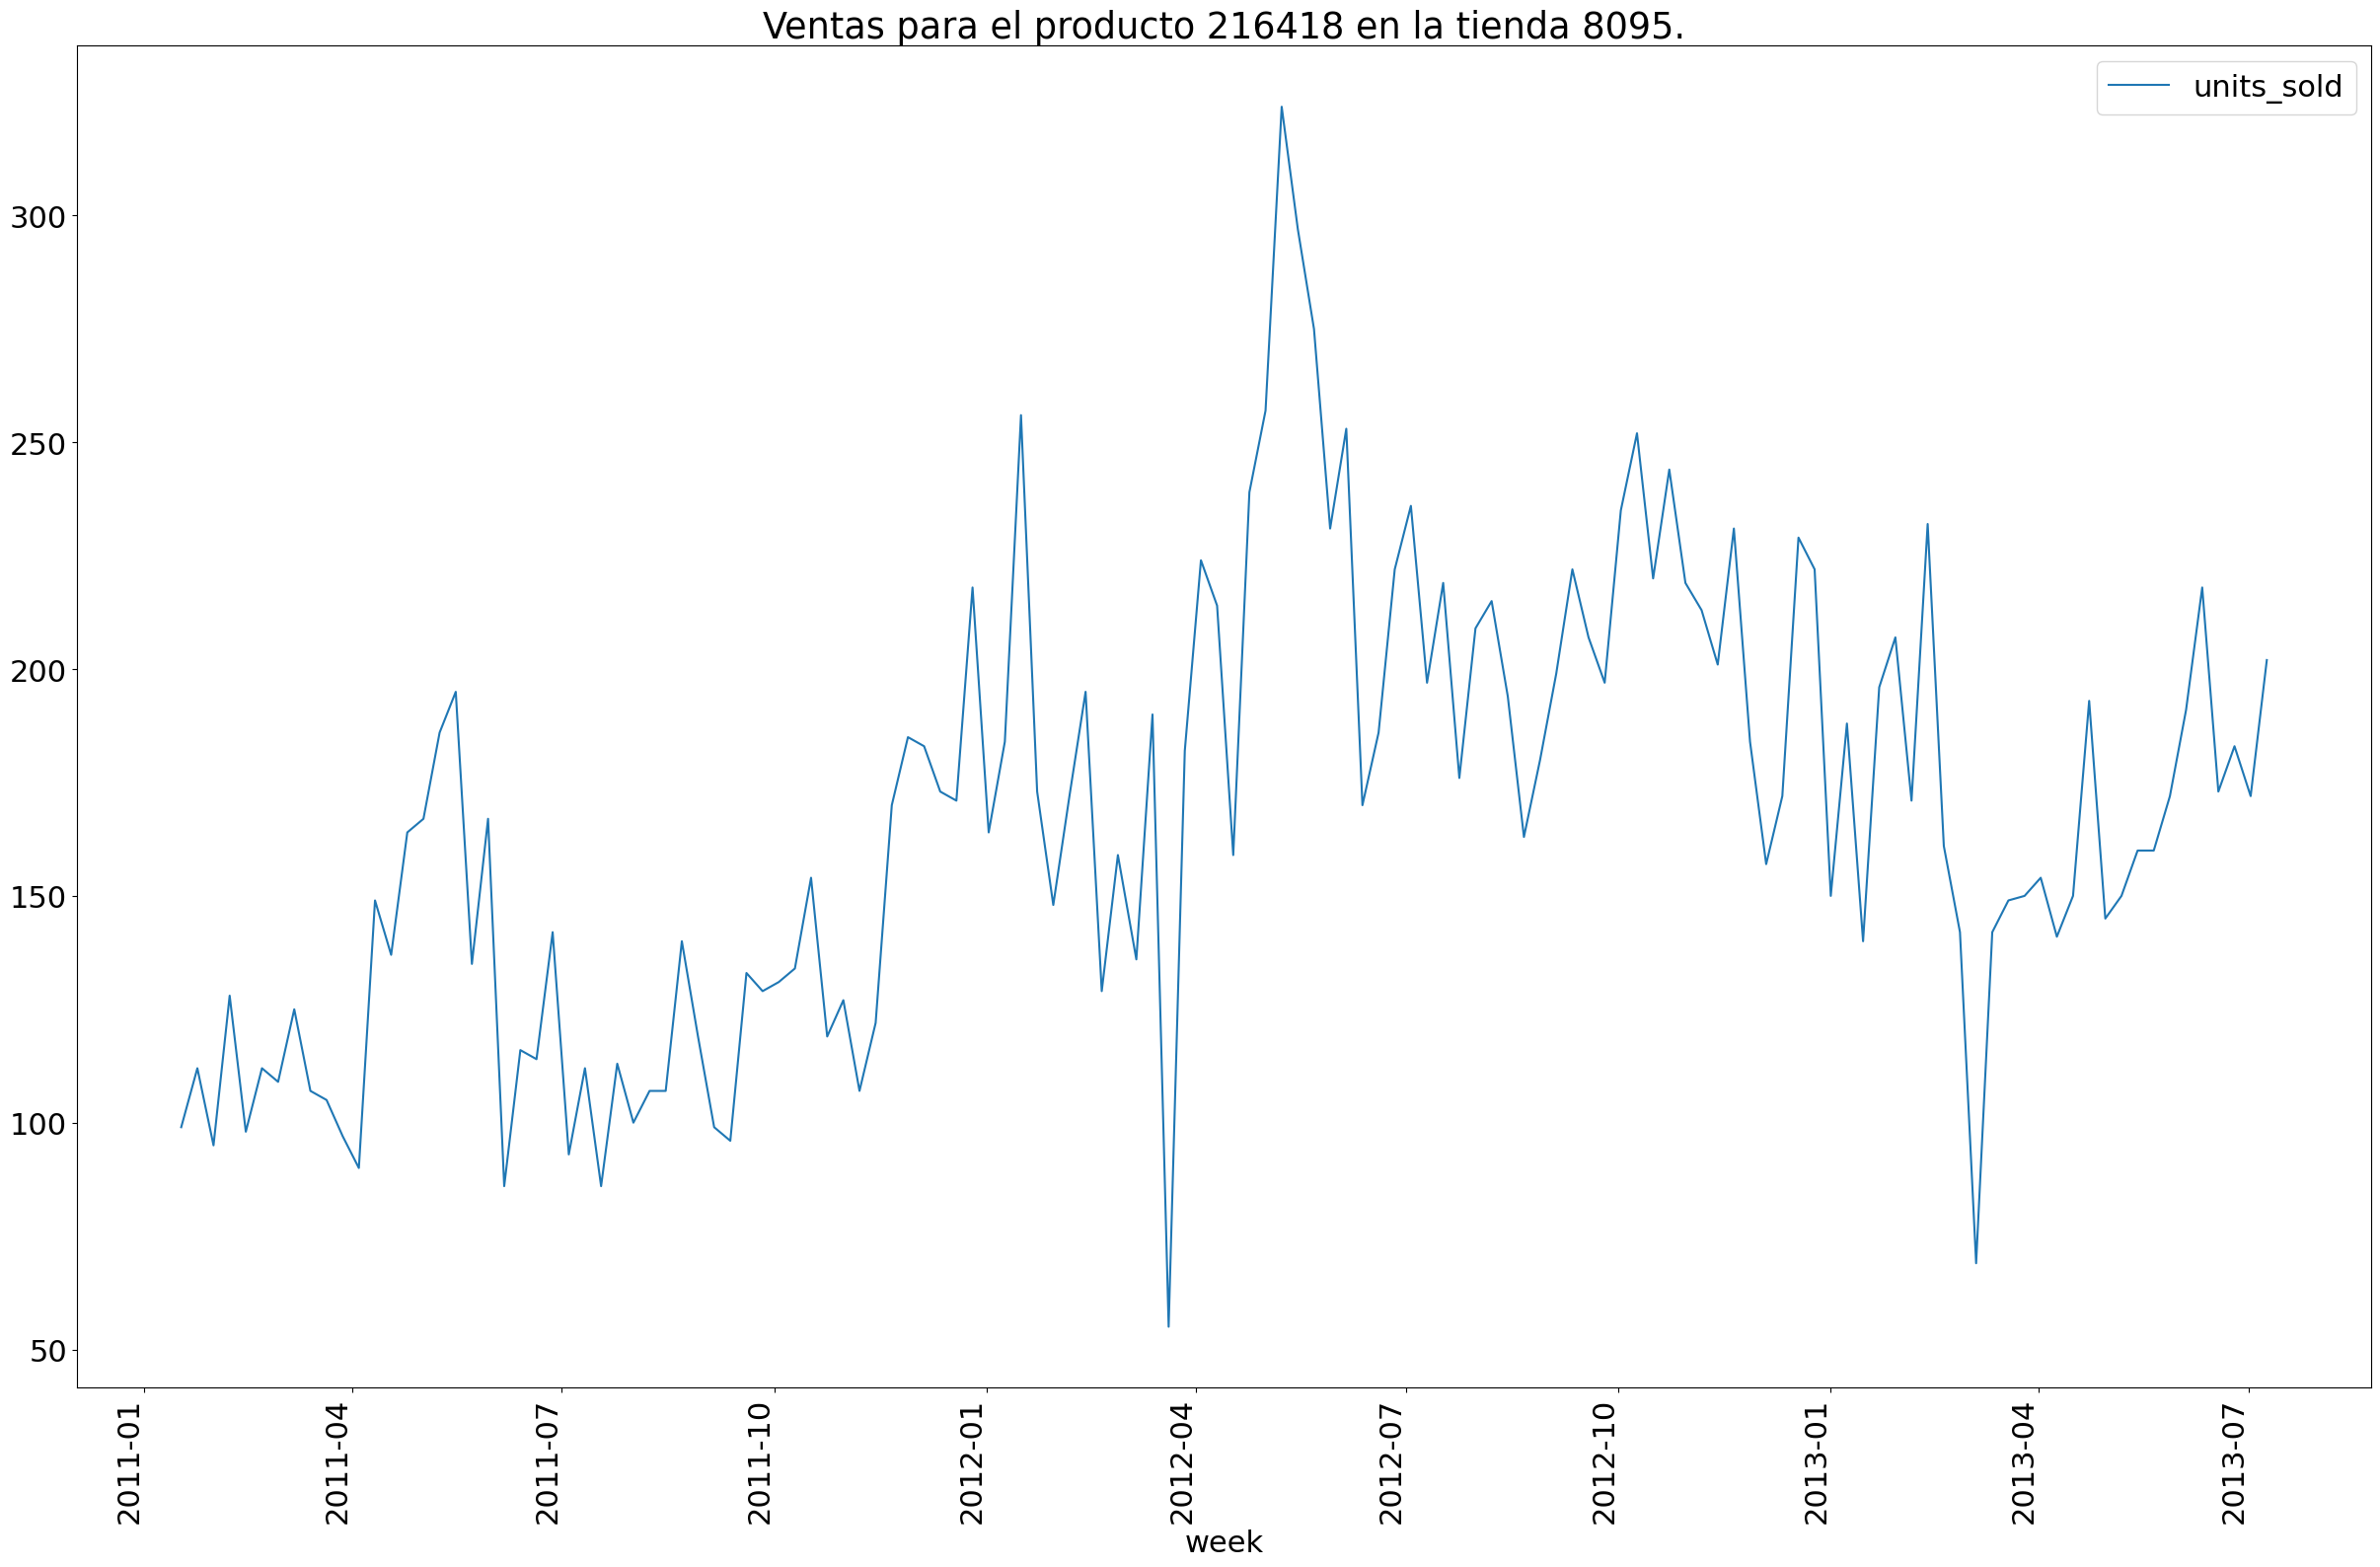

In [ ]:
plot_sales(df, list_sku_id[0], list_store_id[1])

En este caso, más allá de la visualización tampoco ganamos demasiado. Sin embargo, hay en casos en los que estas visualizaciones pueden ser la clave. Por ejemplo, si sabemos el país en el que son las ventas y tenemos acceso a datos como cuáles son los festivos del país, si ha habido promociones de los productos, etc., puede ser de mucha ayuda incorporar esos datos a nuestros modelos.

Ejercico 13: igual que hicimos con "is_featured_sku" e "is_display_sku", calcular cuál es el impacto de la tienda y el producto en las unidades vendidas. En particular, representar gráficamente la media de "units_sold" para cada valor de "store_id" en función de "store_id"; repetir la operación para "sku_id".

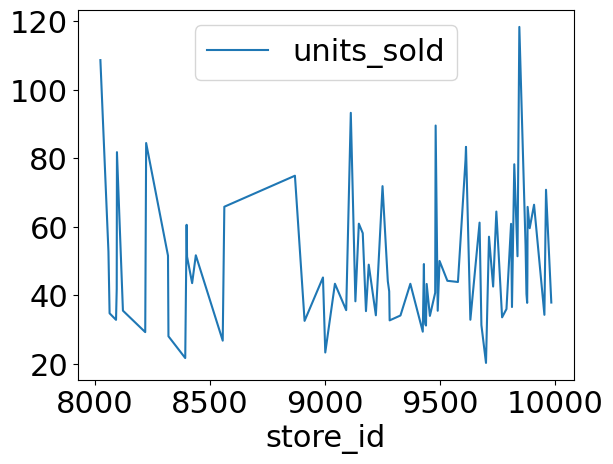

In [ ]:
# Respuesta (sigue en la siguiente)
df[["store_id", "units_sold"]].groupby(["store_id"]).mean("units_sold").plot();

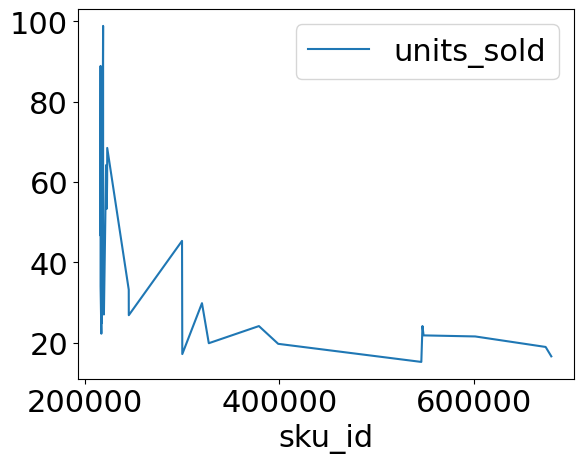

In [ ]:
df[["sku_id", "units_sold"]].groupby(["sku_id"]).mean("units_sold").plot();

Vemos que tanto "store_id" como "sku_id" tienen una clara correlación con las ventas, así que se pueden usar como predictores.

## Separación en entrenamiento y test
Como vimos en las clases y en la demo de aprendizaje supervisado, es fundamental separar los datos en entrenamiento y test. Antes de hacer la división, notemos que:
* Ahora queremos predecir ventas a futuro.
* La división en entrenamiento y test tiene que simular la situación en la que entrenamos con datos disponibles y predecimos sobre los datos nuevos.

Típicamente, dividimos entre entrenamiento y test eligiendo una fracción de los datos, pongamos por caso un 20%. Entonces, elegimos al azar un 80% de filas, las cuales llevamos a entrenamiento, y el 20% restante van a test. Sin embargo, esto no casa con lo anterior. Las situaciones de predicción van a ser tales que:
* Tenemos un histórico de datos hasta una determinada fecha.
* Queremos generamos predicciones a partir de la semana siguiente.

Es por esto que, para previsión de la demanda, no se aleatorizan las filas, sino que se cogen todas las filas anteriores a una fecha, las cuales van a entrenamiento, y el resto van a test.

Ejercicio 14: dividir en entrenamiento y test. Para ello, considerar en entrenamiento todos los puntos anteriores a la semana del 7 de mayo de 2013 y considerar en test el resto.

In [ ]:
# Respuesta

# definimos la fecha, primero como carácter
str_date_split = "2013-05-07"
# la transformamos en formato tipo fecha
date_split = datetime.strptime(str_date_split, "%Y-%m-%d")
# separamos nuestros datos con la mencionada fecha
df_train = df.loc[df.week < date_split]
df_test = df.loc[df.week >= date_split]

In [ ]:
df_train.shape

NameError: name 'df_train' is not defined

## Ingeniería de variables

Ejercicio 15: en caso de haber encontrado correlaciones altas entre las variables numéricas, hacer PCA de las mismas considerando como número de componentes desde una hasta el número total de variables. Antes de hacer la PCA, estandarizar las variables. Una vez hecha la PCA, representar cómo cambia la variabilidad con el número de componentes. _Nota_: ¡No olvides mirar esto en el conjunto de entrenamiento!

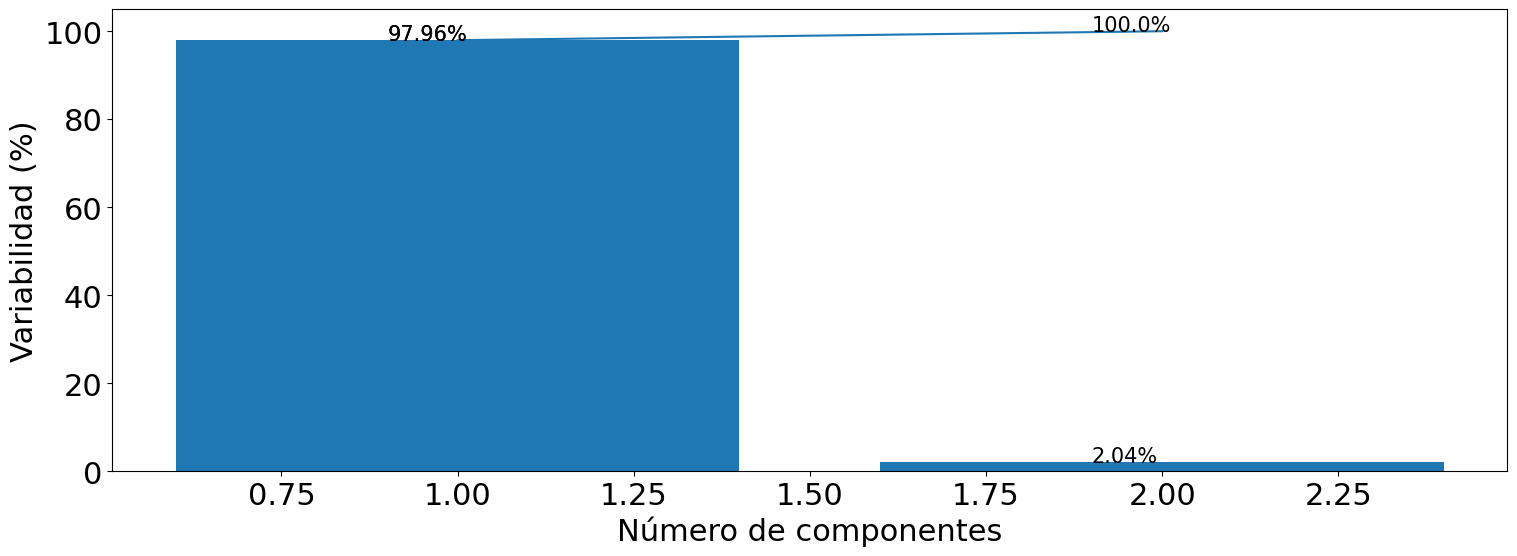

In [ ]:
# Respuesta (sigue en las siguientes celdas)

# Definimos una función para estandarizar las variables y hacer PCA.
def do_pca(X, n):
    sc = StandardScaler()
    X = sc.fit_transform(X)
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

# Definimos otra función para representar cuánto de las correlaciones es captado por el PCA
# en función del número de componentes.
def pca_importance(pca):
    components = pca.components_  # Axis of maximum variation
    n = len(components)
    x = np.arange(n)
    values = pca.explained_variance_ratio_ * 100
    acvalues = np.cumsum(values)

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.bar(x + 1, values)
    ax.plot(x + 1, acvalues)
    for i in x:
        ax.annotate("{}%".format(round(values[i], 2)), (i + 1 -.1, values[i]),
                    fontsize=15)
        ax.annotate("{}%".format(round(acvalues[i], 2)), (i + 1 -.1, acvalues[i]),
                    fontsize=15)
    ax.set_xlabel("Número de componentes")
    ax.set_ylabel("Variabilidad (%)")

# Hacemos PCA y nos quedamos con hasta dos componentes
pca_prices, X_pca = do_pca(df_train[["base_price", "total_price"]], 2)

# la representamos
pca_importance(pca_prices)

Ejercicio 16: en el caso de que el análisis de PCA deje claro que podemos aplicar reducción de la dimensionalidad en algún caso concreto, encontrar la transformación en el conjunto de entrenamiento y aplicarla al conjunto de test.

In [ ]:
# Respuesta (sigue en la siguiente celda):

# Como hemos visto, "total_price" y "real_price" están altamente correlacionadas.
# Con solo una componente, recuperamos casi un 98%, así que nos quedamos con una.
# Decir que encontramos la transformación en el conjunto de entranamiento
# y la aplicamos en test (esto último en la siguiente celda).

# Previamente, quitamos las variables en entrenamiento.
df_train.drop(columns=["total_price", "base_price"], inplace=True)

# Ya hemos encontrado la transformación en el ejercicio anterior, así que simplemente creamos la columna "PCA_price"
# en el conjunto de entrenamiento convenientemente.
df_train["PCA_price"] = X_pca[:,0]


In [ ]:
# Aplicamos la transformación en test
X_pca_test = pca_prices.transform(df_test[["base_price", "total_price"]])
df_test["PCA_price"] = X_pca_test[:,0]

# Prescindimos de las columnas también en test
df_test.drop(columns=["total_price", "base_price"], inplace=True)

No vamos a considerar más ingeniería de variables por una serie de razones:
* De nuestras variables categóricas, dos de ellas ("is_display_sku" e "is_featured_sku") ya están perfectamente codificadas.
* Las dos variables categóricas restantes ("store_id" y "sku_id") tienen demasiada variabilidad como para considerar _one-hot encoding_. Podría tener sentido considerar una codificación alternativa, como por ejemplo algo tipo _count encoding_, pero existe la posibilidad que la codificación numérica con la que llegan ya tenga cierto sentido. En cualquier caso, os sugiero que probéis _count encoding_ u otras codificaciones si queréis jugar un poco con estos datos.
* Desconocemos la naturaleza de los productos vendidos y de las tiendas en las que se vende (de qué tipo de productos hablamos, si las tiendan son pequeños comercios o grandes superficies, etc.). En caso contrario, se podría incorporar información adicional que podría ser relevante. Por ejemplo, si sabemos que se trata de productos con mucha estacionalidad, incorporar variables tipo "es verano" o "es Navidad" puede ayudar. Sin embargo, carecemos de esta información. De las representaciones que hemos hecho anteriormente de ventas en función de la fecha para un determinado producto en una tienda dada, tampoco extramos ninguna conclusión clara. Finalmente, si representamos las ventas promedio en función de la fecha (ver siguiente ejercicio), tampoco apreciamos ningún patrón claro.

Ejercicio 17: representar la media de las unidades vendidas en cada semana en función de la semana, confirmando que no hay ningún patrón claro.

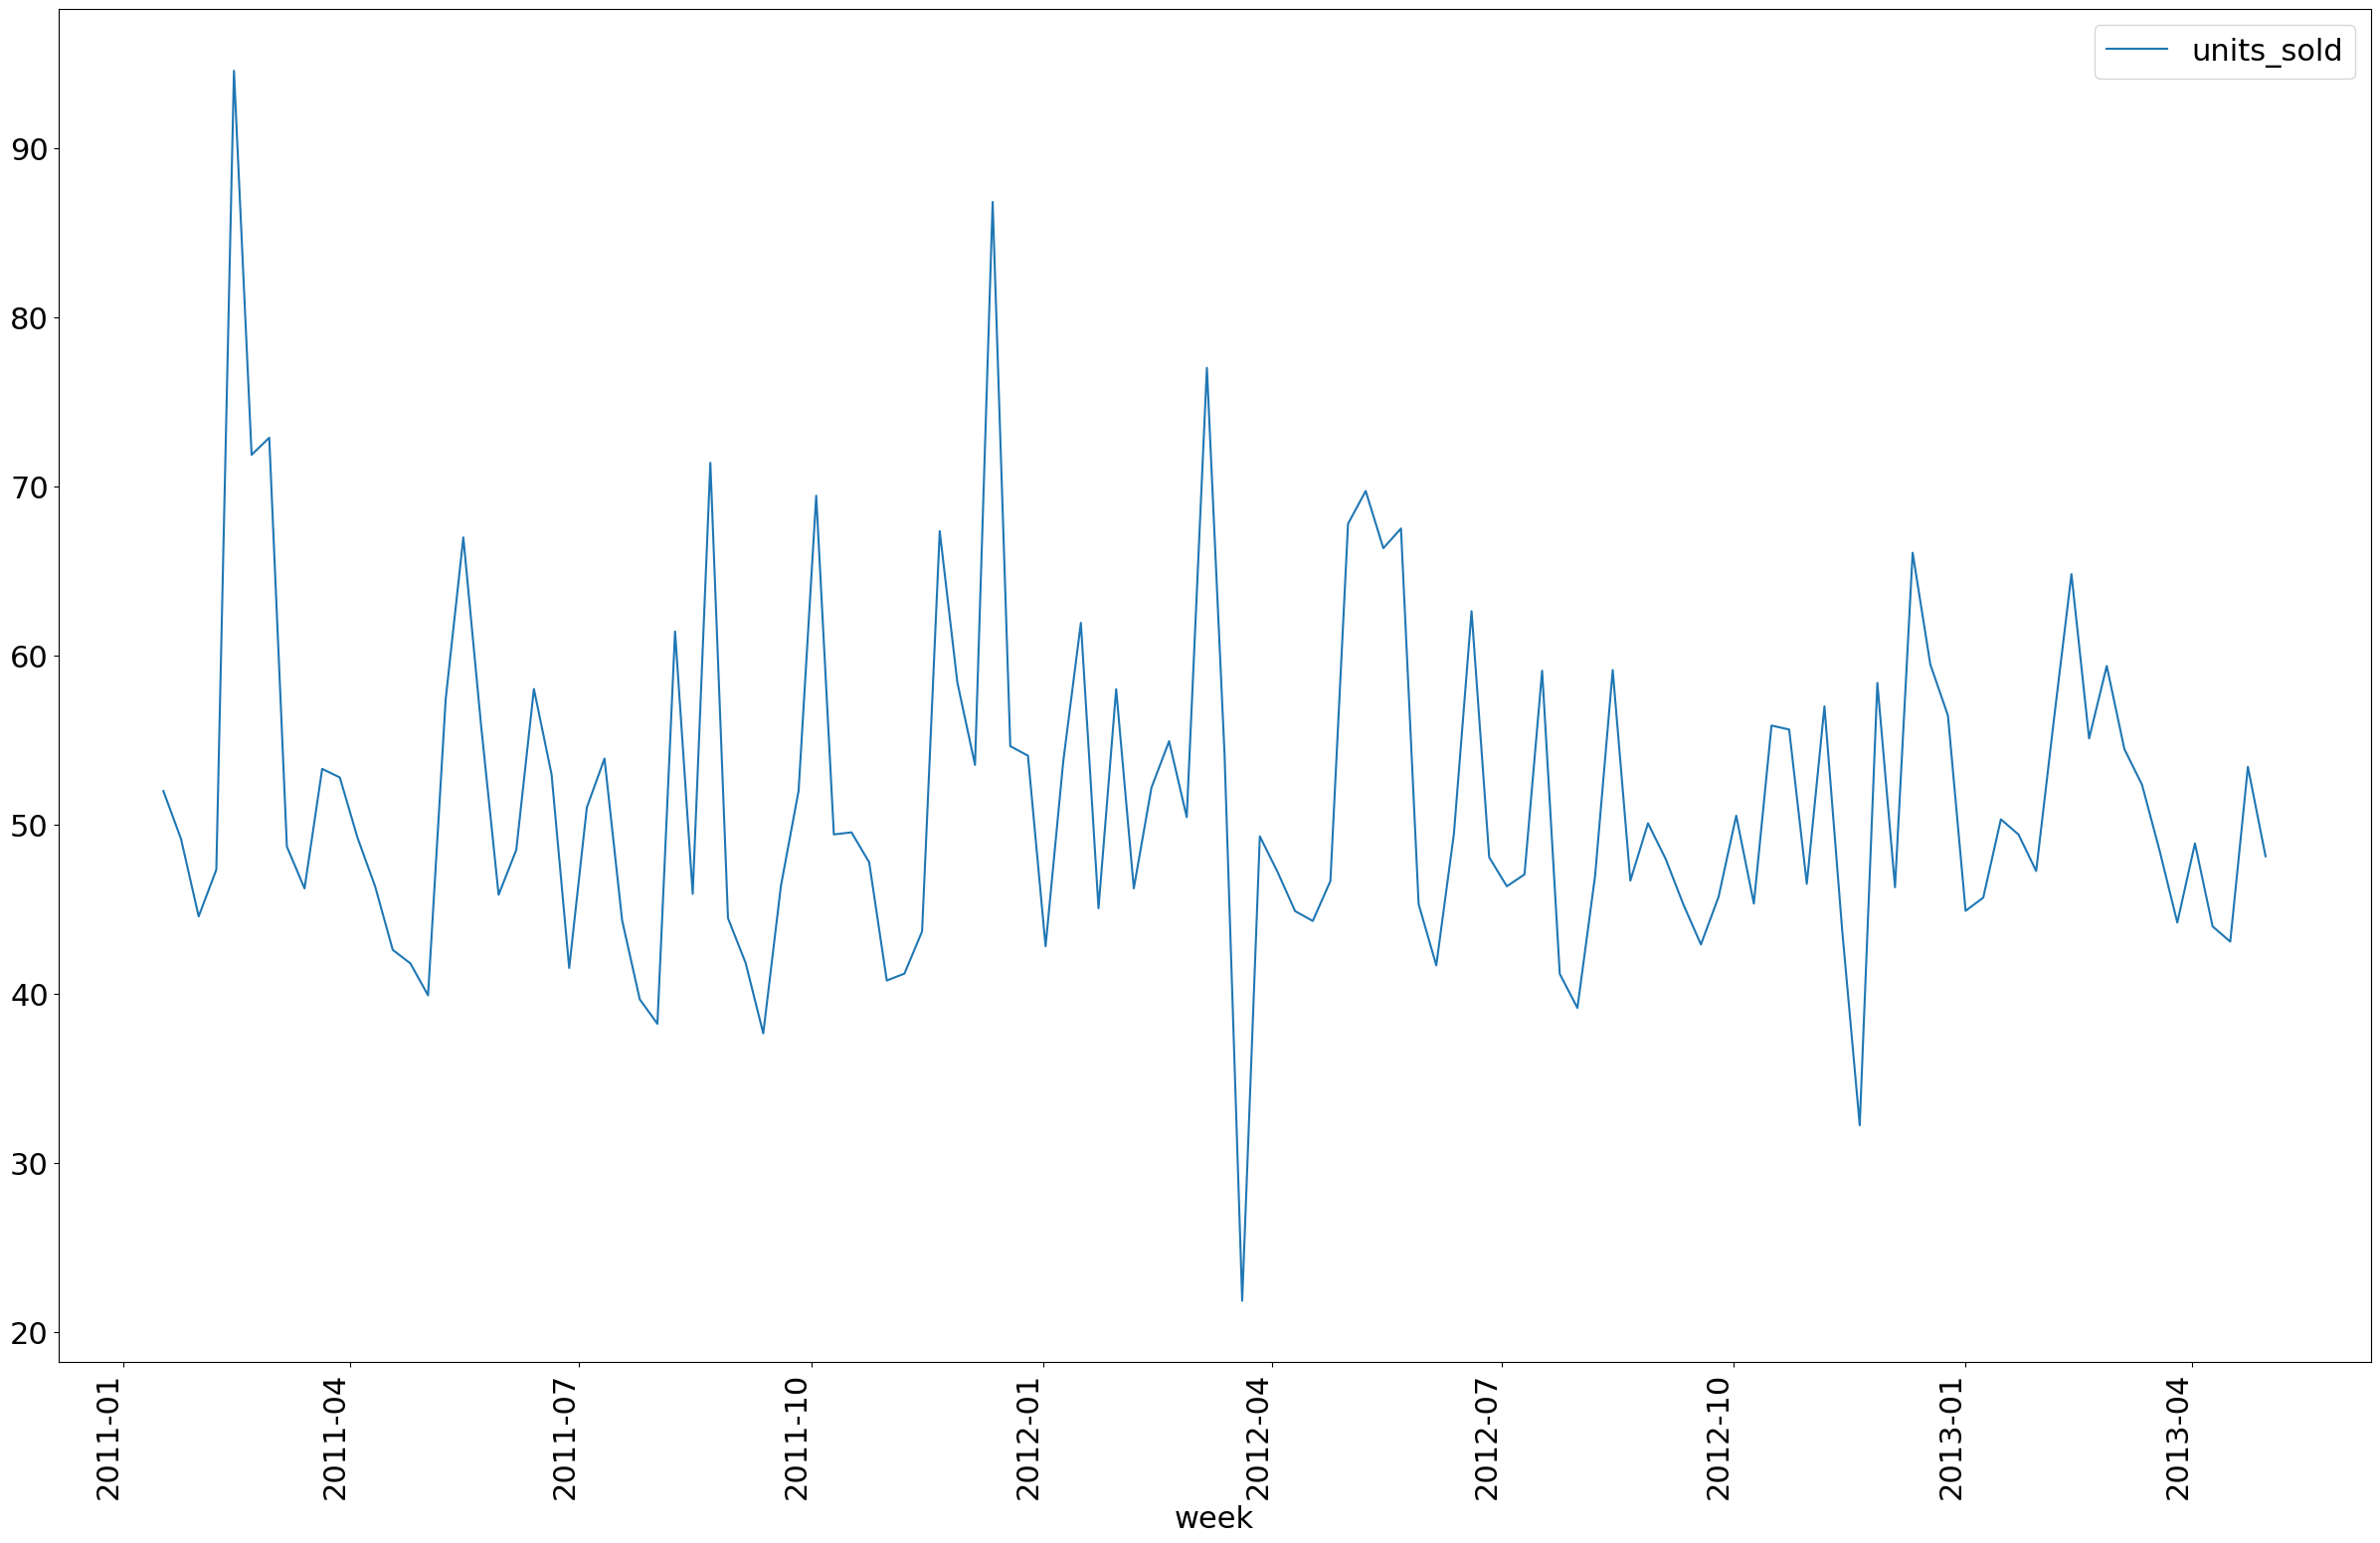

In [ ]:
# Respuesta:

# Notar que utilizamos el conjunto de entrenamiento. Siendo rigurosos, todos los análisis,
# incluso los que hemos hecho en la parte del principo, deberían haberse realizado así
ax = df_train[["week", "units_sold"]].groupby(by="week").mean().plot(figsize=(30, 20));
plt.xticks(rotation=90);

Vemos una serie de picos más o menos erráticos que no parecen vinculados a ningún periodo del año en concreto (verano, Navidad, etc.), así que confirmamos que incorporar información adicional relativa a la fecha no debería aportar demasiado.

# Modelo: Random Forest

Utilizaremos solo el Random Forest.

## Entrenamiento

Ejercicio 18: definir el modelo. Recordar que es la clase RandomForestRegressor (no Classifier, al tratarse de un problema de variable continua). No haremos validación cruzada, así que tenemos que fijar los hiperparámetros de antemano al definir el objeto. Elegiremos:

* random_state: 42997296
* n_estimators: 200
* max_depth: 20
* criterion: "squared_error"
* max_features: None
* bootstrap: True
* oob_score: True
* max_samples: 0.6

Para ello, ir a la documentación de la página: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
model_RF = RandomForestRegressor(random_state=42997296,
                                 n_estimators=200,
                                 max_depth=20,
                                 criterion="squared_error",
                                 max_features=None,
                                 bootstrap=True,
                                 oob_score=True,
                                 max_samples=0.6)

Ejercicio 19: ajustar el modelo utilizando el conjunto de entrenamiento. Recordad que se hace con el método fit de la clase RandomForestClassifier, al que hay que pasarle los argumentos X e y, siendo el primero la matriz de predictores y el segundo los valores de la variable objetivo.

In [ ]:
model_RF.fit(X=df_train.drop(columns=["week", "units_sold"]),
             y=df_train.units_sold)

RandomForestRegressor(max_depth=20, max_features=None, max_samples=0.6,
                      n_estimators=200, oob_score=True, random_state=42997296)

## Análisis de resultados en entrenamiento

Ejercicio 20: alamcenar en forma de numpy.array las predicciones. Después, asignarlas a una nueva columna de df_train "units_sold_pred".

In [ ]:
array_preds_train = model_RF.predict(df_train.drop(columns=["week", "units_sold"]))
df_train["units_sold_pred"] = array_preds_train

Ejercicio 21: escribir una función para mostrar tanto las ventas como sus predicciones de un determinado producto en una tienda dada en función de la semana.

<Figure size 640x480 with 0 Axes>

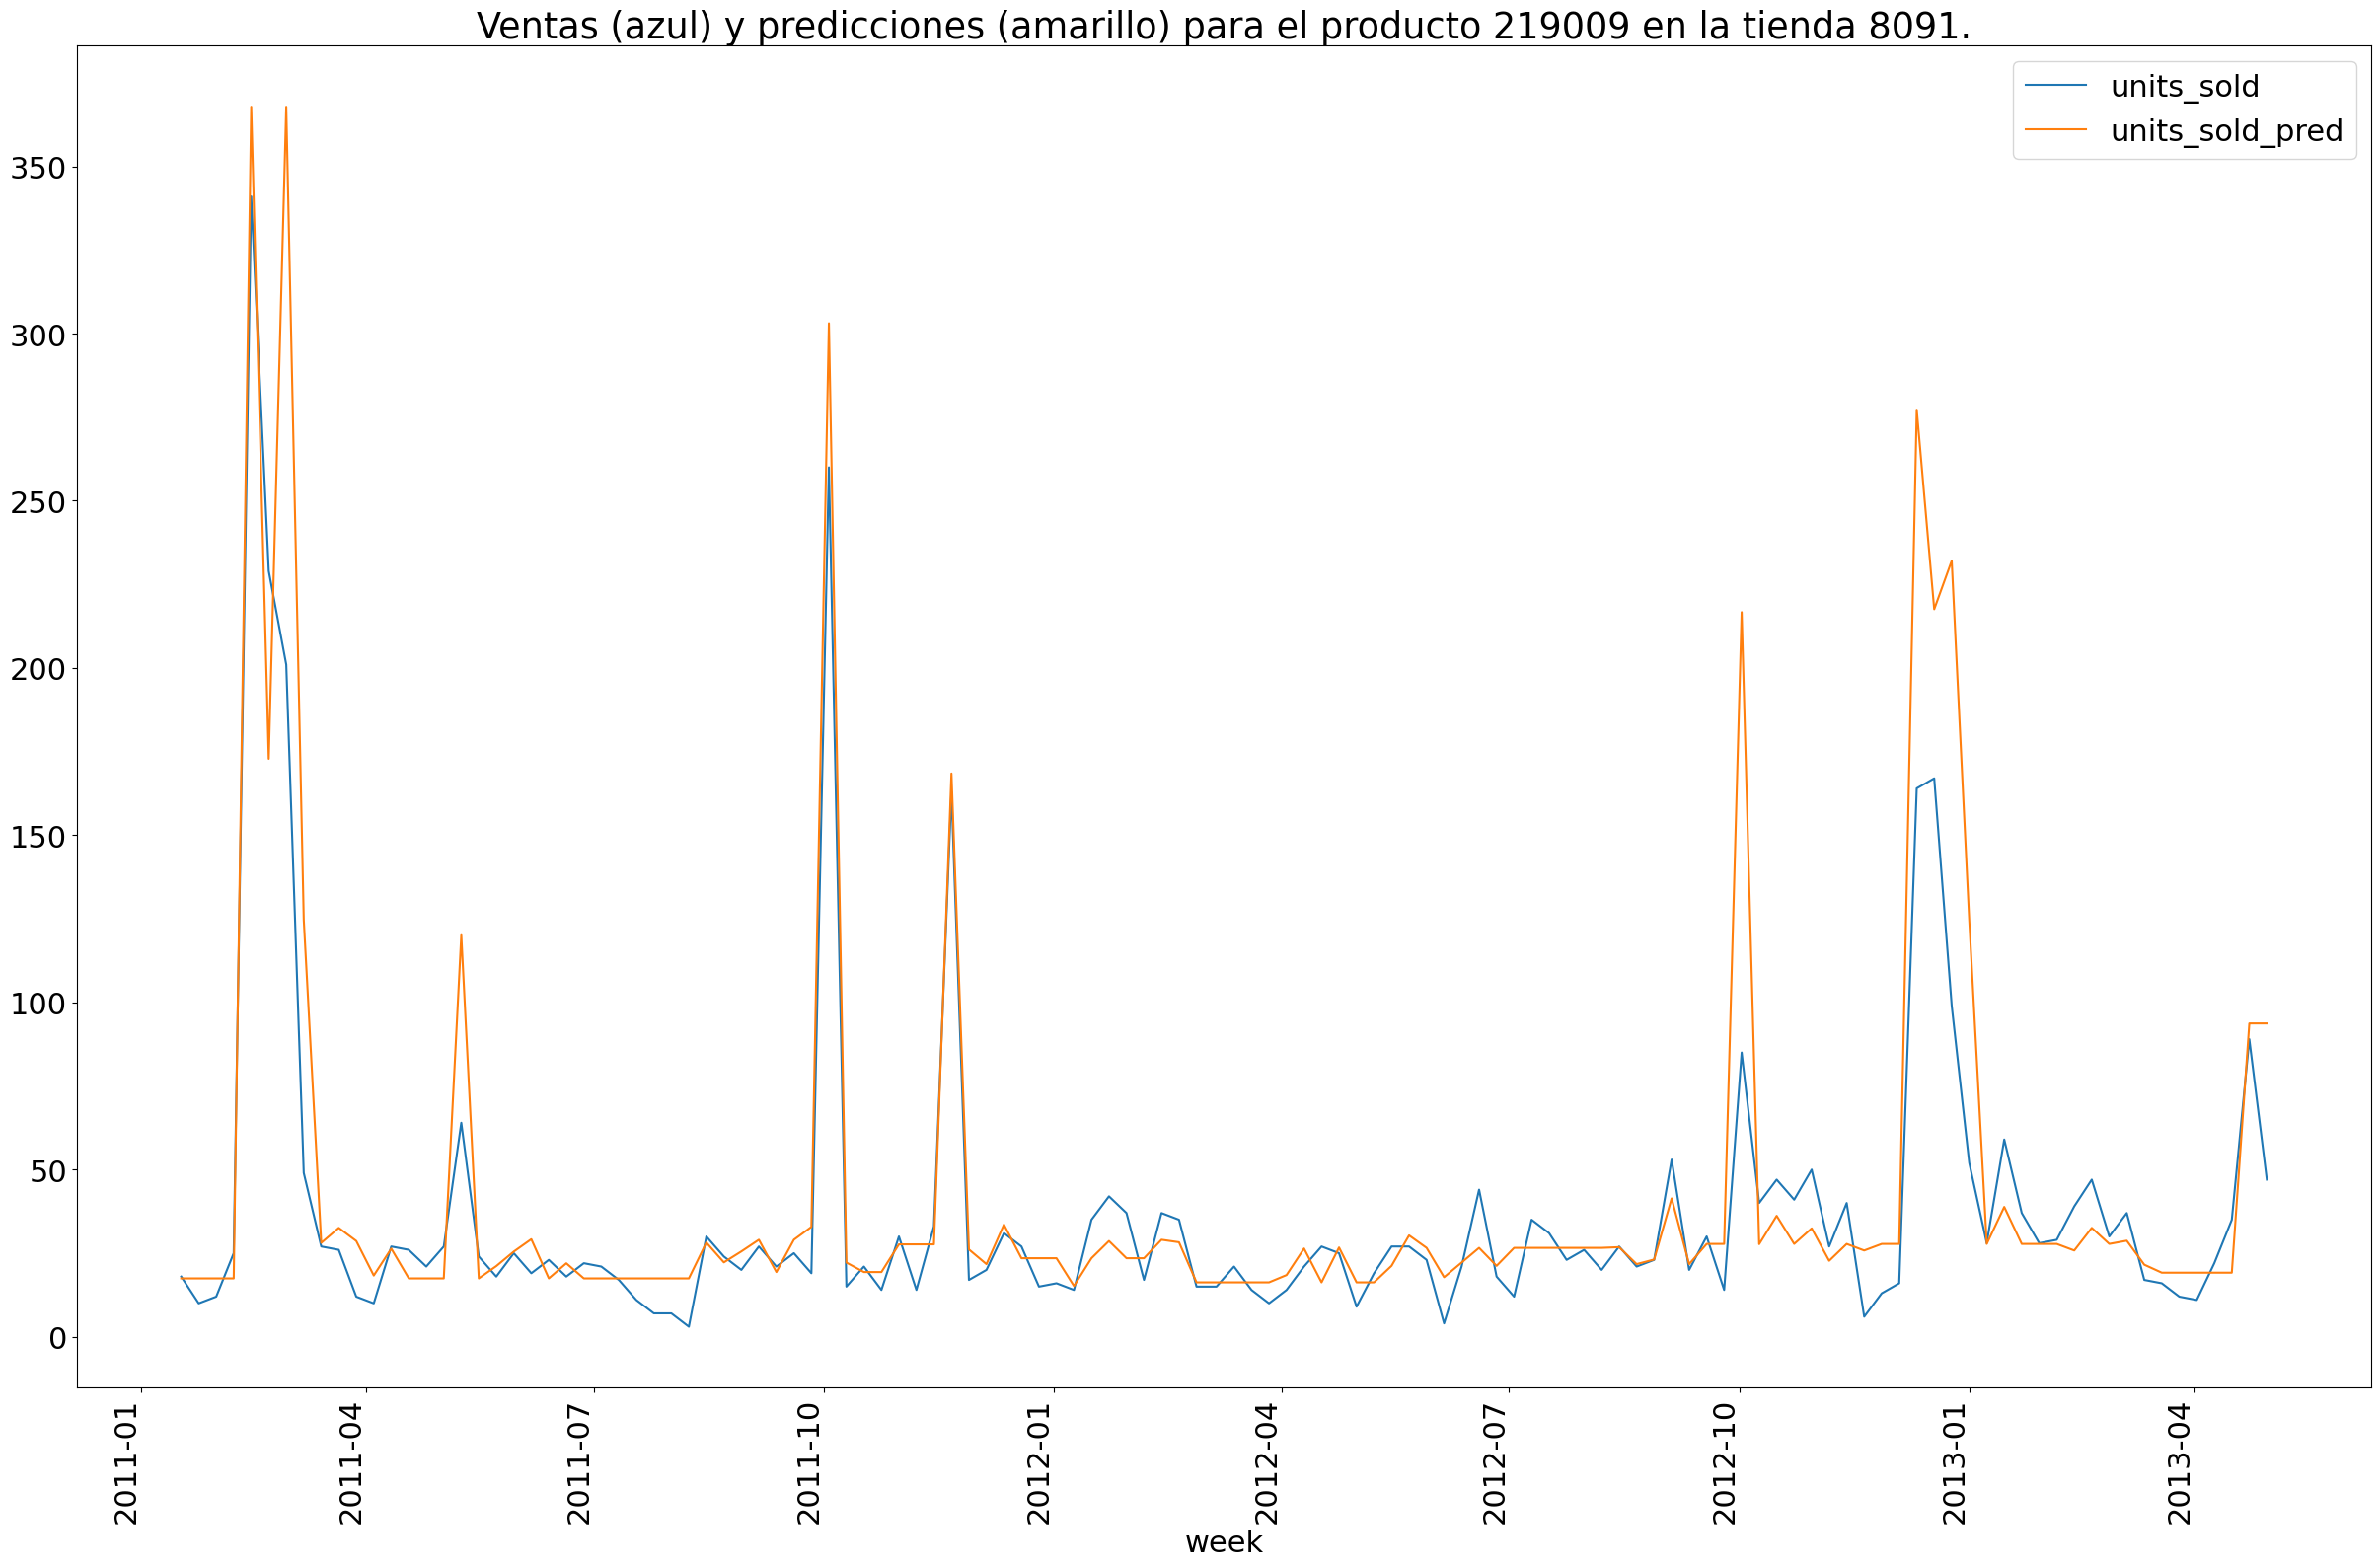

In [ ]:
# Respuesta (sigue en las siguientes celdas)

# Escribimos la función:
def plot_sales_and_preds(df, str_sku, str_store):
    """
    Esta función parte de un producto y una tienda y dibuja las ventas
    en función del tiempo.
    """
    plt.figure()
    plt.rcParams.update({'font.size': 22})

    srs_bool_filter = (df.sku_id == str_sku) & (df.store_id == str_store)
    ax = df.loc[srs_bool_filter, ["week", "units_sold", "units_sold_pred"]].set_index(keys="week").plot(figsize=(30, 20))
    ax.set_title("Ventas (azul) y predicciones (amarillo) para el producto " + str(str_sku) + " en la tienda " + str(str_store) + ".")
    plt.xticks(rotation=90)

# Representamos ya algún ejemplo
plot_sales_and_preds(df_train, list_sku_id[5], list_store_id[0])

<Figure size 640x480 with 0 Axes>

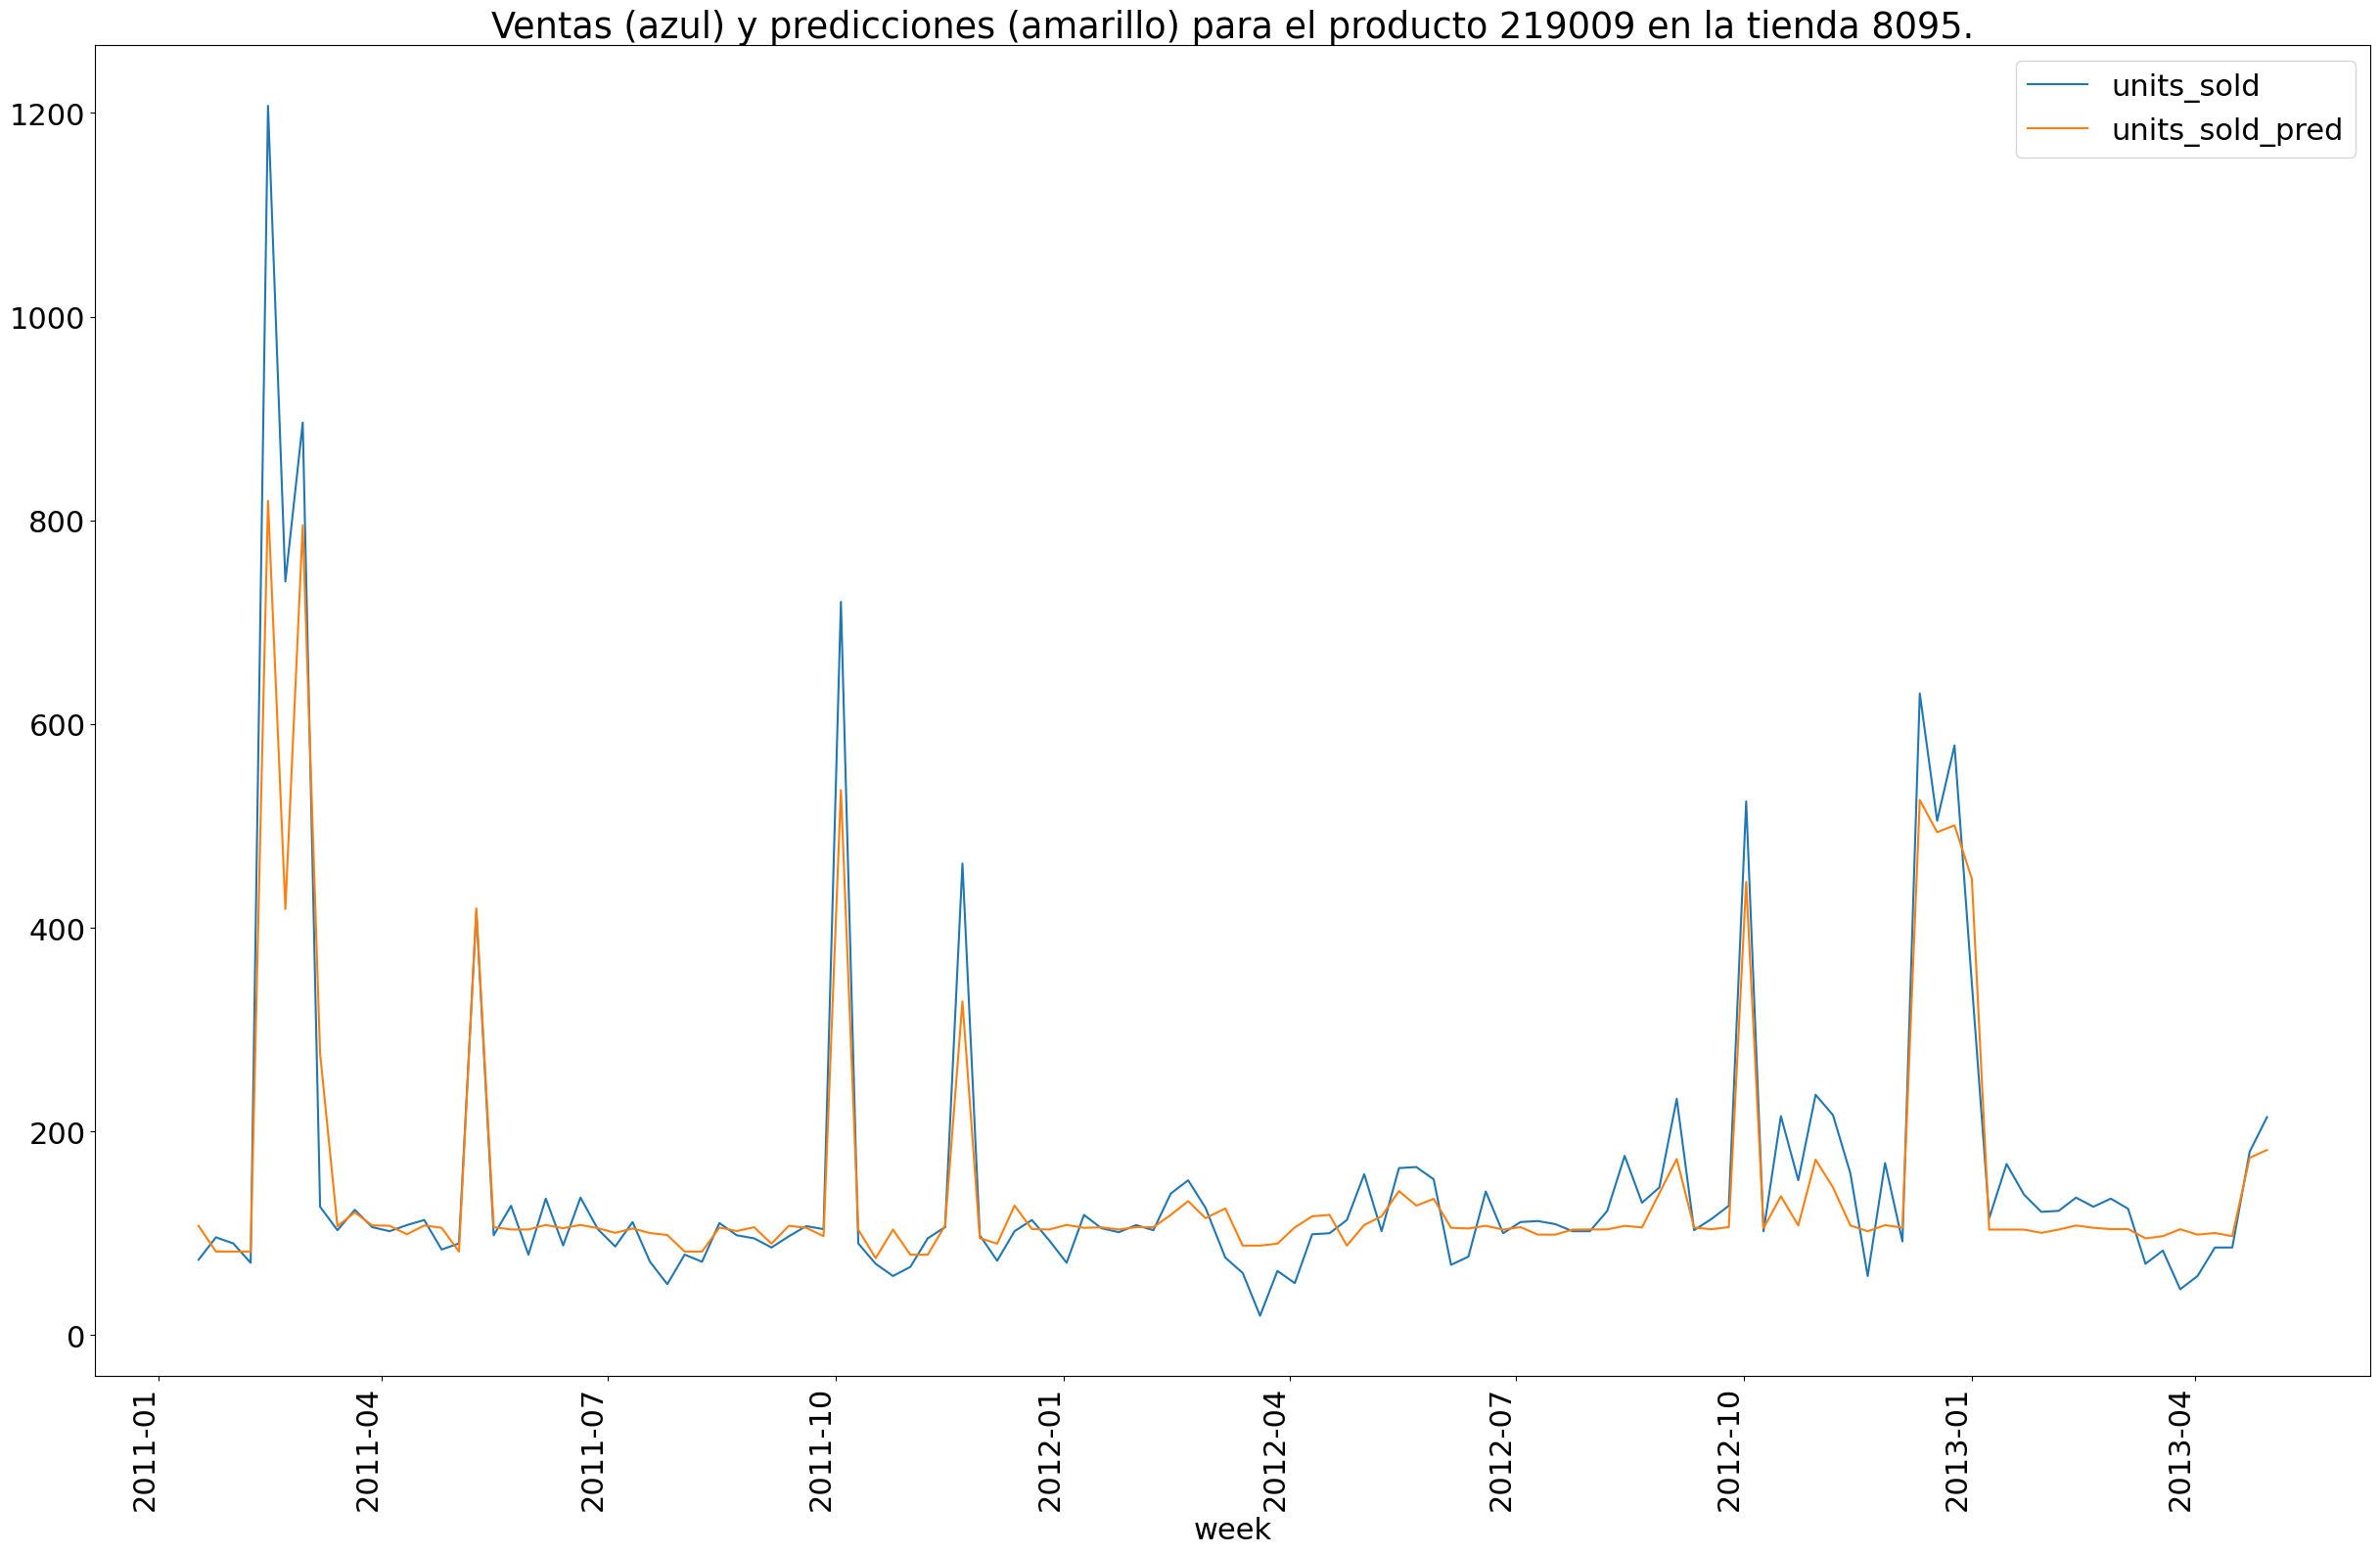

In [ ]:
plot_sales_and_preds(df_train, list_sku_id[5], list_store_id[1])

Ejercicio 22: calcular el error cuadrático medio dividido por la media de las ventas, así como el coeficiente $R^2$ en el conjunto de entrenamiento.

In [ ]:
# Definimos una función para hacer estos cálculos e imprimirlos por pantalla
def get_mse_and_r2(df):
    num_mse = mean_absolute_error(df.units_sold, df.units_sold_pred) / df.units_sold.mean()
    num_r2 = r2_score(df.units_sold, df.units_sold_pred)
    print("El error cuadrático medio normalizado por la media es: {}\nEl coeficiente R2 es: {}".format(num_mse, num_r2))
    return num_mse, num_r2

# Lo calculamos
num_mse_train, num_r2_train = get_mse_and_r2(df_train)

Ejercicio 23: Mostrar las predicciones en función de las ventas reales, así como las diferencias entre predicciones y ventas, todo ello en función de las ventas.

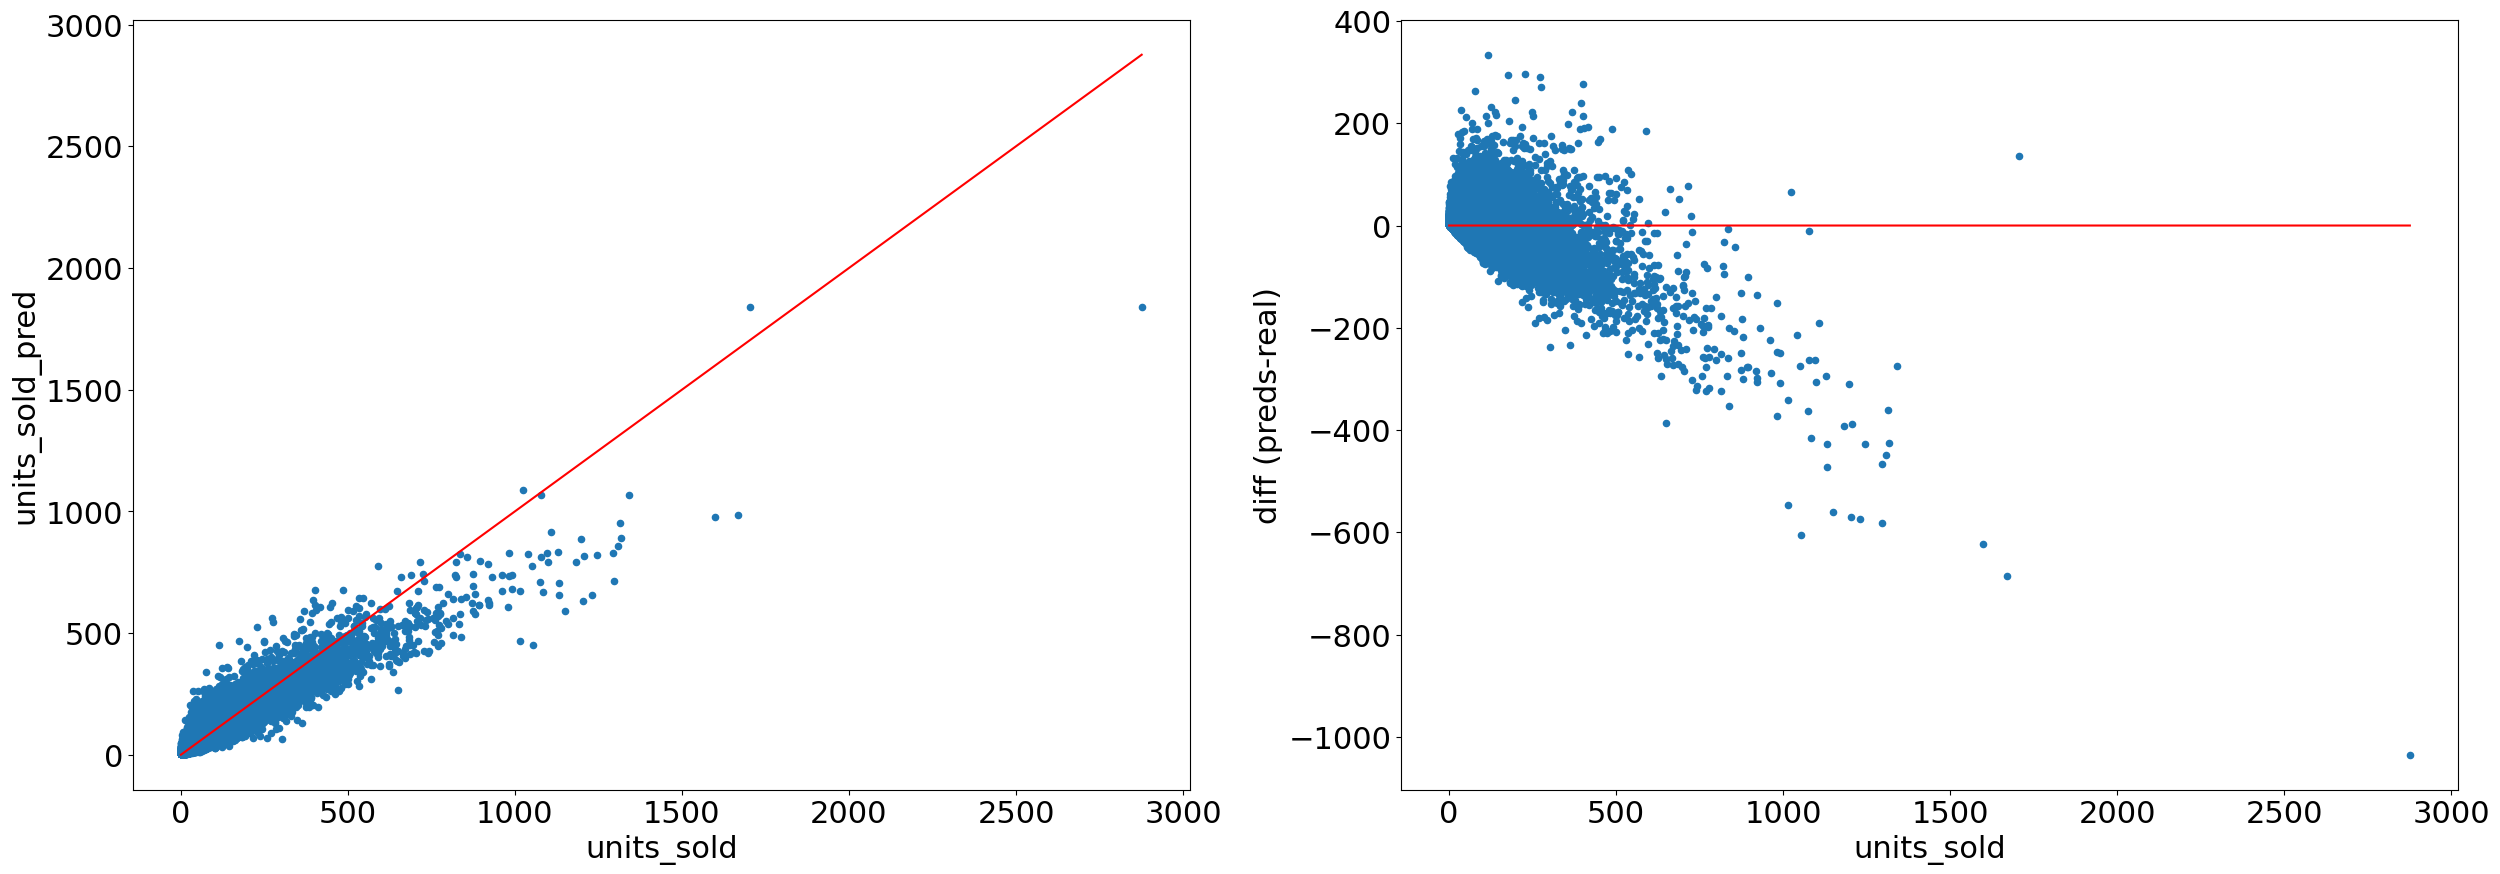

In [ ]:
# Respuesta:

# Definimos primero una función que genera las gráficas pertinentes.
def plot_preds_diff(df):

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(30, 10)
    y = df.units_sold
    y_preds = df.units_sold_pred
    pd.DataFrame({"units_sold": y, "units_sold_pred": y_preds}).plot(kind="scatter",
                                                                     x="units_sold",
                                                                     y="units_sold_pred",
                                                                     ax=ax[0]);
    pd.DataFrame({"units_sold": y, "units_sold_2": y}).sort_values(by="units_sold").plot(x="units_sold",
                                                                                         y="units_sold_2",
                                                                                         ax=ax[0],
                                                                                         color="red",
                                                                                         legend=False);

    pd.DataFrame({"units_sold": y, "diff (preds-real)": y_preds - y}).plot(kind="scatter",
                                                              x="units_sold",
                                                              y="diff (preds-real)",
                                                              ax=ax[1]);
    pd.DataFrame({"units_sold": y, "perfect_model": 0}).sort_values(by="units_sold").plot(x="units_sold",
                                                                                          y="perfect_model",
                                                                                          ax=ax[1],
                                                                                          color="red",
                                                                                          legend=False);
# Representamos
plot_preds_diff(df_train)

Sin duda alguna, sobre todo en la gráfica de las diferencias, las predicciones tienden a estar por debajo de los valores reales en el caso de valores altos de las ventas reales. Esto significa que el modelo no termina de captar bien los picos. Quizás hayáis podido observar esto ya al representar curvas de ventas y predicciones en función del tiempo, dependiendo de la combinación de tienda y producto seleccionada.

## Análisis de resultados en test

Ejercicio 24: almacenar como numpy.array las predicciones en test y calcular el error cuadrático medio normalizado para la media y el coeficiente $R^2$.

In [ ]:
# Respuesta:

# Calculamos las predicciones y se las asignamos a la tabla df_test
array_preds_test = model_RF.predict(df_test.drop(columns=["week", "units_sold"]))
df_test["units_sold_pred"] = array_preds_test

# calculamos las métricas mencionadas
get_mse_and_r2(df_test)

El error cuadrático medio normalizado por la media es: 0.648658038321933
El coeficiente R2 es: 0.06787151059512597


(np.float64(0.648658038321933), 0.06787151059512597)

Ejercicio 25: representar ventas reales y predicciones para alguna combinación dada de producto y tienda en test.

<Figure size 640x480 with 0 Axes>

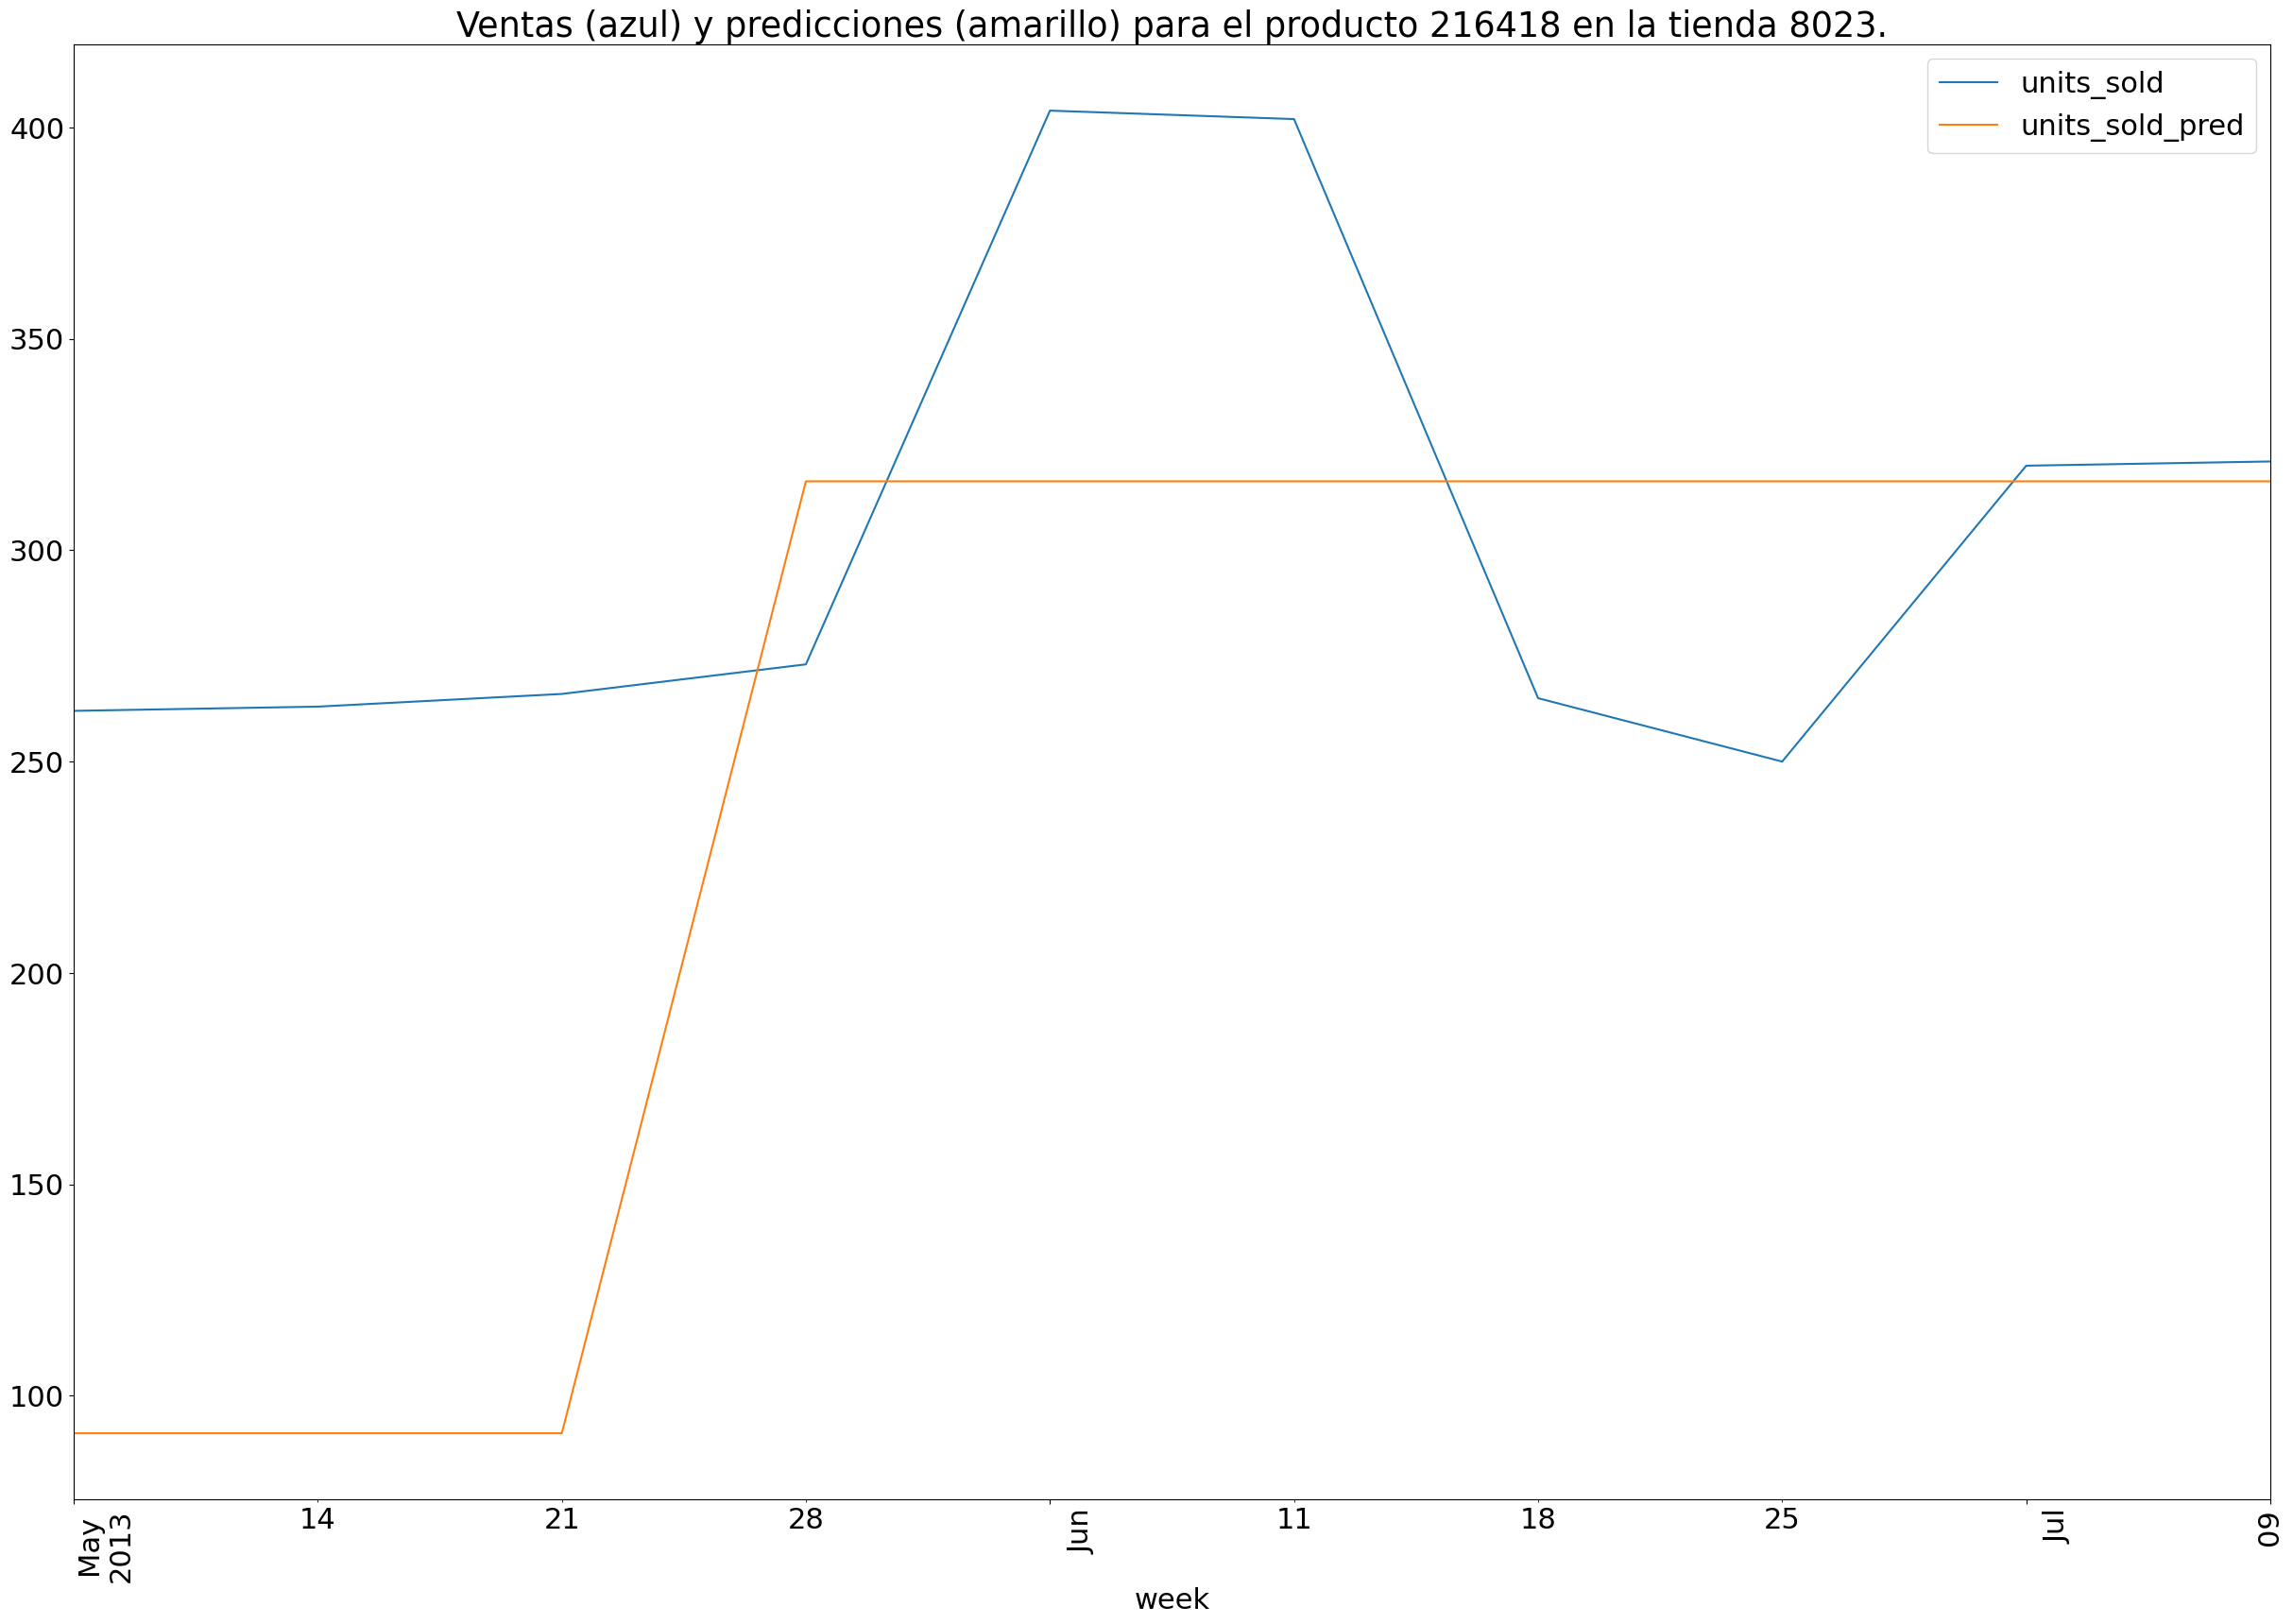

In [ ]:
# Respuesta

plot_sales_and_preds(df_test, list_sku_id[0], list_store_id[4])

Ejercicio 26: representar las predicciones y las diferencias entre predicciones y ventas reales en función de las ventas.

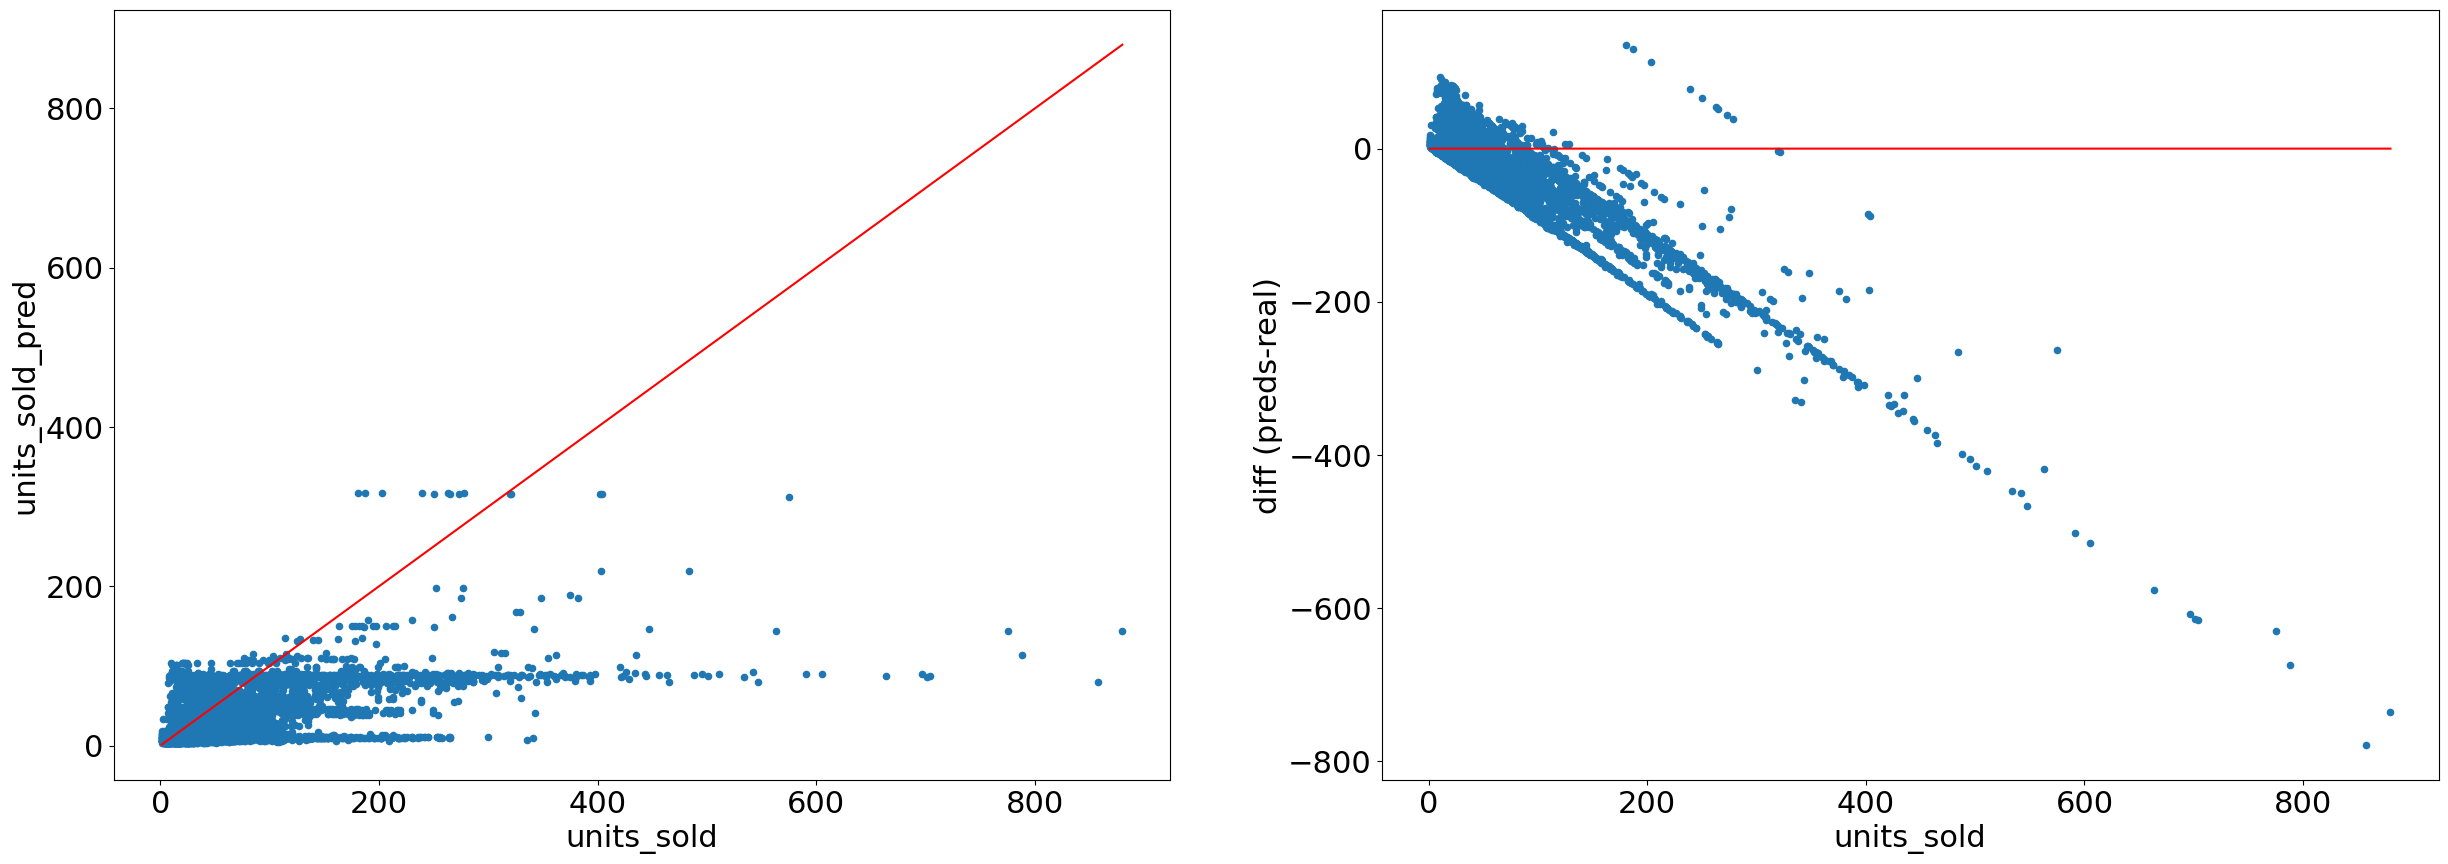

In [ ]:
# Respuesta
plot_preds_diff(df_test)

Está claro que los resultados en test son mucho peores que en entrenamiento. Es por esto que tenemos que explorar varias vías de mejora.

## Mejora 1: incorporar la semana del año

Probemos a incorporar la semana del año.

Ejercicio 27: calcular para df_train y df_test una columna que nos dé el número de semana del año. _NOTA_: dada una columna de un pandas DataFrame de tipo fecha, podemos acceder a sus distintos parámetros (día, semana, mes, año, etc.) con el atributo .dt.day, .dt.week, .dt.month, .dt.year, etc. respectivamente.

In [ ]:
df_train["week_number"] = df_train.week.apply(lambda x: x.week)
df_test["week_number"] = df_test.week.apply(lambda x: x.week)

Ejercicio 28: entrenar un nuevo modelo incorporando el número de semana. Evaluar su rendimiento en entrenamiento y test.

In [ ]:
model_RF.fit(X=df_train.drop(columns=["week", "units_sold", "units_sold_pred"]),
             y=df_train.units_sold)

array_preds_train = model_RF.predict(df_train.drop(columns=["week", "units_sold", "units_sold_pred"]))
df_train["units_sold_pred"] = array_preds_train

array_preds_test = model_RF.predict(df_test.drop(columns=["week", "units_sold", "units_sold_pred"]))
df_test["units_sold_pred"] = array_preds_test

num_mse_train, num_r2_train = get_mse_and_r2(df_train)
num_mse_test, num_r2_test = get_mse_and_r2(df_test)

El error cuadrático medio normalizado por la media es: 0.19834344966452108
El coeficiente R2 es: 0.9059191202947191
El error cuadrático medio normalizado por la media es: 0.6298498197612352
El coeficiente R2 es: 0.09008279038575606


Vemos que hemos mejorado algo, pero aún hay camino por recorrer.

## Mejora 2: variables _lagged_

Al tratar problemas de previsión de la demanda con algoritmos de aprendizaje automático supervisado, conviene derivar variables _lagged_. Esto significa que, para una fila, además de considerar las ventas correspondientes a la combinación de tienda, semana y producto, añadimos ventas correspondientes a semanas anteriores.

Añadimos a continuación una función, get_lagged_sales(), la cual recibe como argumentos nuetra tabla (un pandas DataFrame) y el número de semanas para el cual queremos calcular la variable _lagged_ y devuelve un pandas DataFrame con solo una columna con la variable que queremos calcular. Además, cambia los na por 0.

In [ ]:
def get_lagged_sales(df, int_lag):
    list_cols = ["sku_id", "store_id", "units_sold"]
    list_cols_gb = ["sku_id", "store_id"]
    str_col_name = "units_sold_" + str(int_lag)
    df_lagged = df[list_cols].groupby(list_cols_gb).shift(int_lag).rename(columns={"units_sold": str_col_name})
    df_lagged.fillna(0, inplace=True)
    return df_lagged

Notar que necesitamos utilizar el conjunto total para calcular las variables _lagged_. De lo contrario, en test nos perderíamos información.

Ejercicio 29: calcular las ventas _lagged_ para el conjunto total para 1, 2, 3, 4 y 5 semanas y almacenarlas en pandas DataFrame independientes.

In [ ]:
# Respuesta:

df_units_sold_1 = get_lagged_sales(df, 1)
df_units_sold_2 = get_lagged_sales(df, 2)
df_units_sold_3 = get_lagged_sales(df, 3)
df_units_sold_4 = get_lagged_sales(df, 4)
df_units_sold_5 = get_lagged_sales(df, 5)

Ejercicio 30: asignar lo que acabamos de calcular a columnas de nuestros conjuntos de entrenamiento y test.

In [ ]:
# Respuesta:

# Lo hacemos asignando directamente las columnas calculadas a nuestras tablas de datos.
# Notar que nuestras tablas de datos tienen menos filas que las columnas calculadas. Sin
# embargo, pandas hace la asignación de forma correcta, ya que tiene en cuenta los
# índices para ello.

df_train["units_sold_1"] = df_units_sold_1
df_train["units_sold_2"] = df_units_sold_2
df_train["units_sold_3"] = df_units_sold_3
df_train["units_sold_4"] = df_units_sold_4
df_train["units_sold_5"] = df_units_sold_5

df_test["units_sold_1"] = df_units_sold_1
df_test["units_sold_2"] = df_units_sold_2
df_test["units_sold_3"] = df_units_sold_3
df_test["units_sold_4"] = df_units_sold_4
df_test["units_sold_5"] = df_units_sold_5

Ejercicio 31: entrenar un modelo con las ventas _lagged_ y determinar sus métricas.

In [ ]:
model_RF.fit(X=df_train.drop(columns=["week", "units_sold", "units_sold_pred"]),
             y=df_train.units_sold)

array_preds_train = model_RF.predict(df_train.drop(columns=["week", "units_sold", "units_sold_pred"]))
df_train["units_sold_pred"] = array_preds_train

array_preds_test = model_RF.predict(df_test.drop(columns=["week", "units_sold", "units_sold_pred"]))
df_test["units_sold_pred"] = array_preds_test

num_mse_train, num_r2_train = get_mse_and_r2(df_train)
num_mse_test, num_r2_test = get_mse_and_r2(df_test)

El error cuadrático medio normalizado por la media es: 0.16933337349912742
El coeficiente R2 es: 0.9306382485875228
El error cuadrático medio normalizado por la media es: 0.38885871758956175
El coeficiente R2 es: 0.6045731425303758


Vemos que hemos mejorado sustancialmente.

Ejercicio 32: Representar ahora las predicciones y las diferencias en función de las ventas reales para entrenamiento y test.

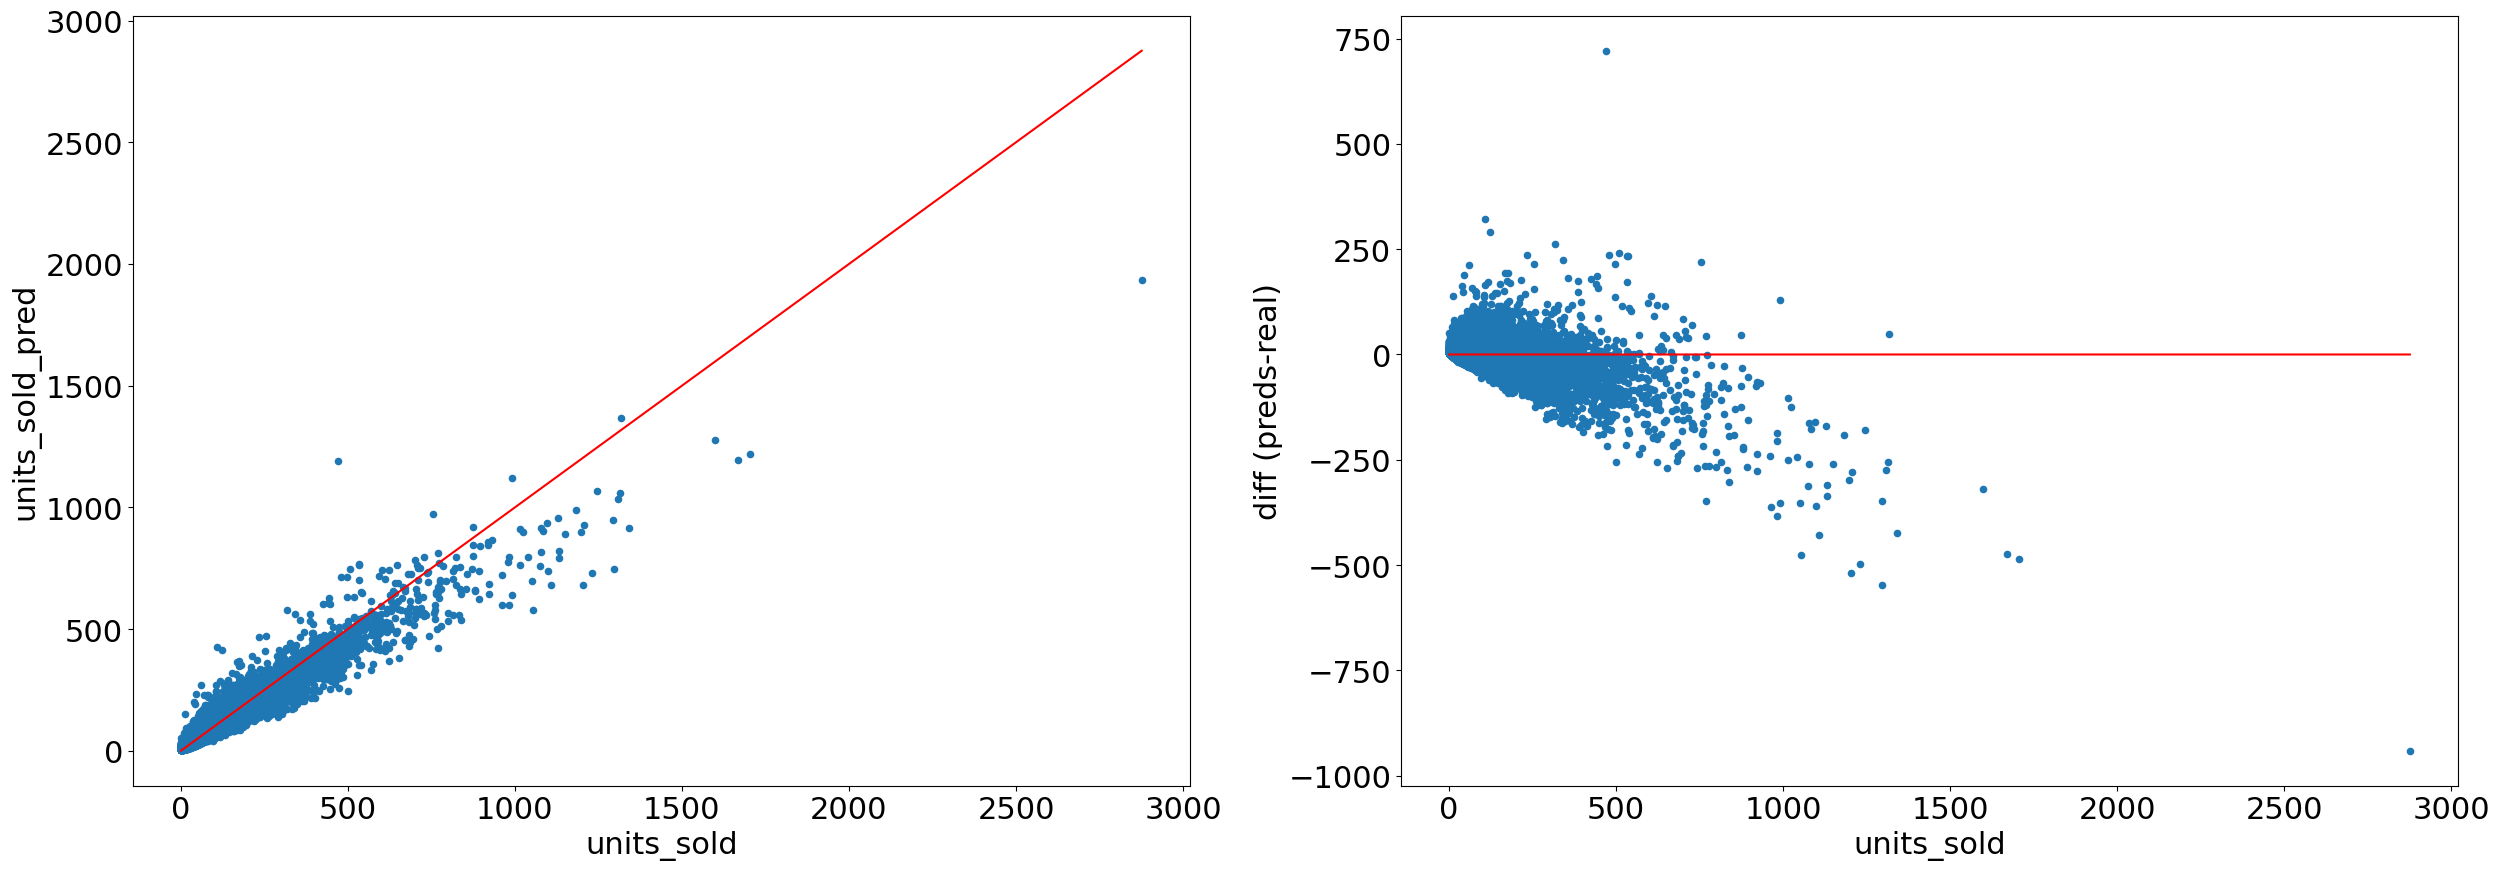

In [ ]:
plot_preds_diff(df_train)

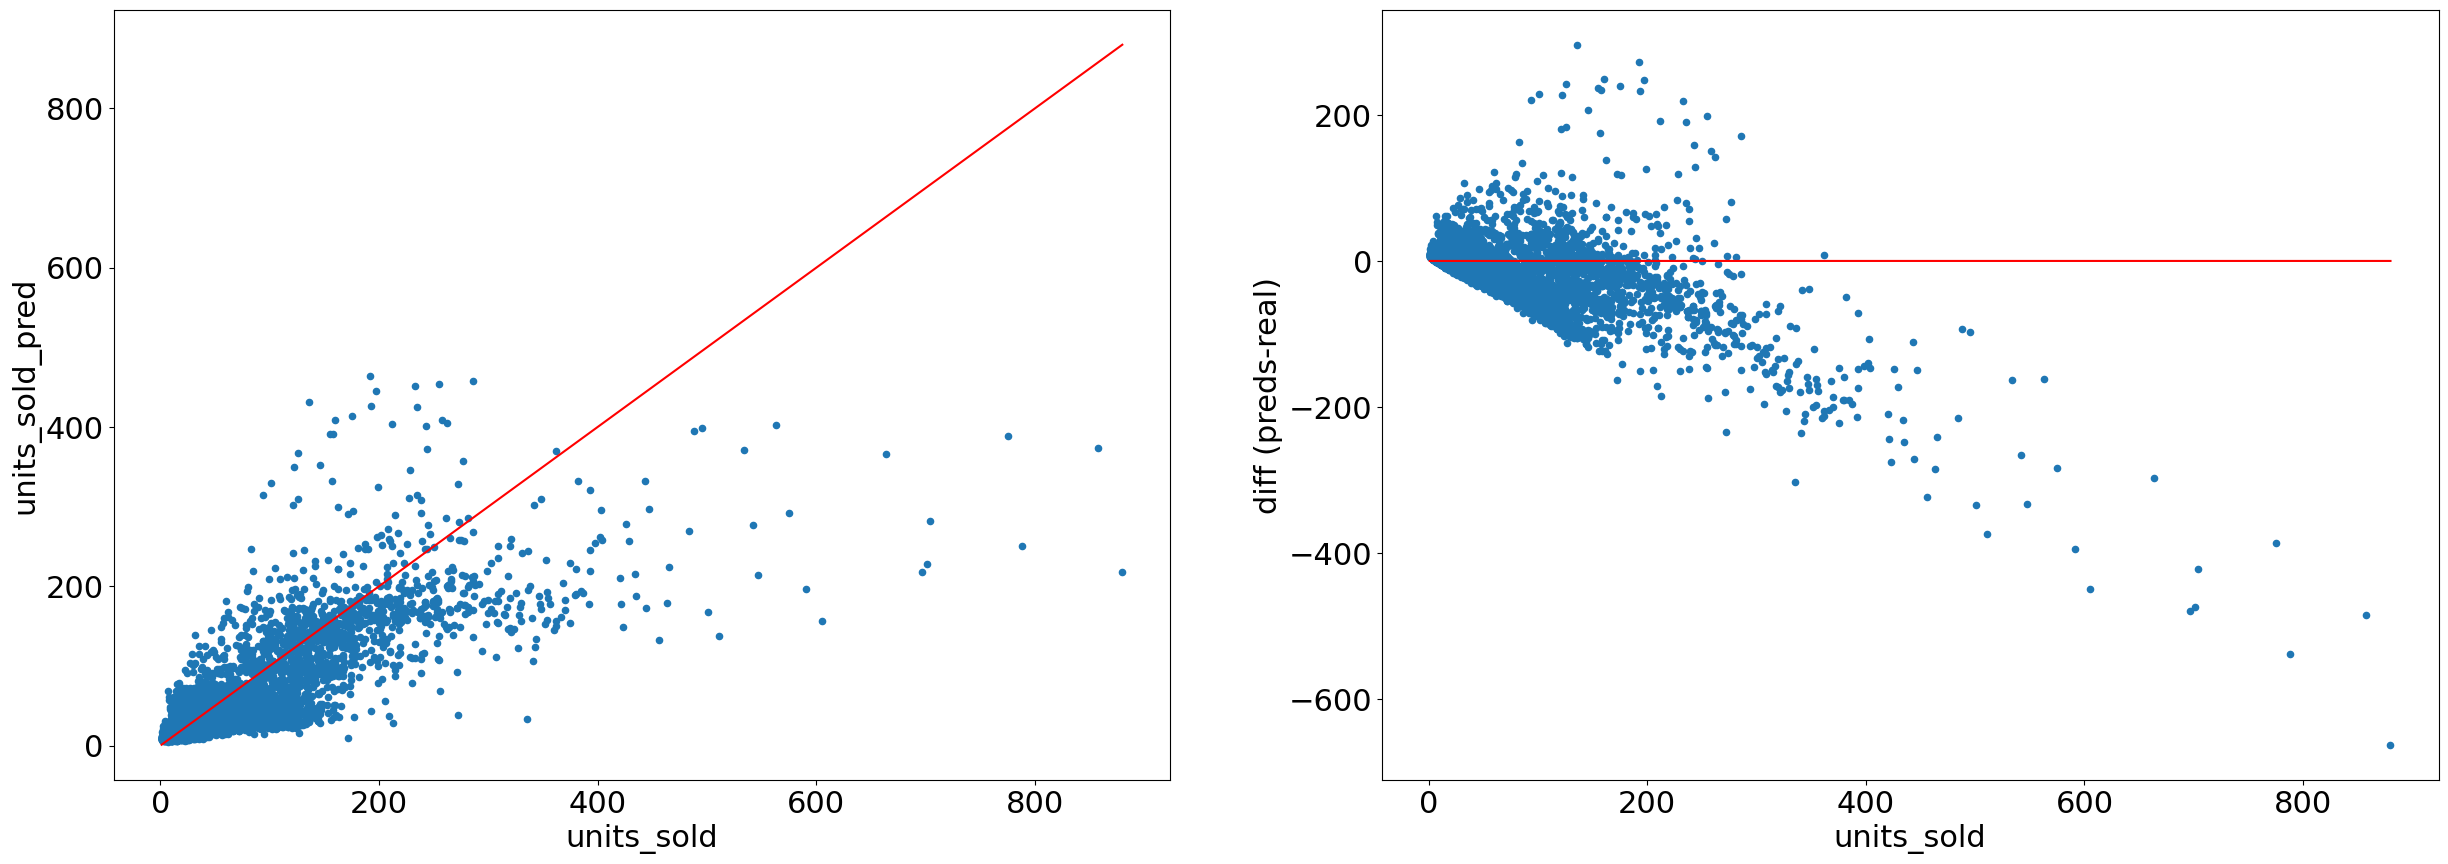

In [ ]:
plot_preds_diff(df_test)

Ahora tiene mucha mejor pinta.

## Relevancia de variables

Para terminar, hacemos un pequeño análisis de relevancia de variables.

Ejercicio 33: determinar la relevancia de variables del modelo. Para ello, notar que el atributo .feature_importances_ de la clase RandomForestClassifier() da un numpy array con la relevancia. Sus columnas correspondientes aparecen en el mismo orden que en la tabla de entrada. Vamos paso por paso:

Ejercicio 33.1: definir una lista con los nombres de las columnas utilizadas.

In [ ]:
list_columns = df_train.drop(columns=["week", "units_sold", "units_sold_pred"]).columns.tolist()

Ejercicio 33.2: obtener el numpy array con la relevancia.

In [ ]:
array_importance = model_RF.feature_importances_

Ejercicio 33.3: construir un pandas DataFrame con dos columnas: una con los nombres des las columnas utilizadas y otra las relevancias. Ordenarlo de mayor a menor relevancia.

In [ ]:
df_feature_relevance = pd.DataFrame(data={"columns": list_columns, "relevance_splits": array_importance})
df_feature_relevance.sort_values(by="relevance_splits", ascending=True, inplace=True)
df_feature_relevance.reset_index(drop=True, inplace=True)

Ejercicio 33.4: representar la relevancia como un diagrama de barras. _Nota_: podemos hacer con el método .plot() de pandas, tomando kind="barh".

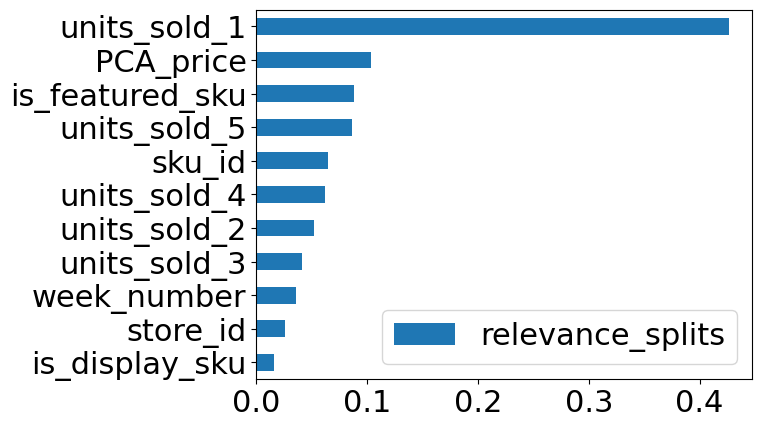

In [ ]:
plot_feature_relevance = df_feature_relevance.plot(kind="barh")
plot_feature_relevance.set_yticklabels(df_feature_relevance["columns"]);

Como vemos, lo más relevante son las ventas de la semana anterior. Esto es muy razonable. Después tenemos un poco de todo, pero hay que destacar que todas las variables relacionadas con las ventas tienden a estar en la zona media-alta de la tabla.

Ejercicio 34: representar las ventas predichas con el último modelo para alguna combinación de tienda y producto.

<Figure size 640x480 with 0 Axes>

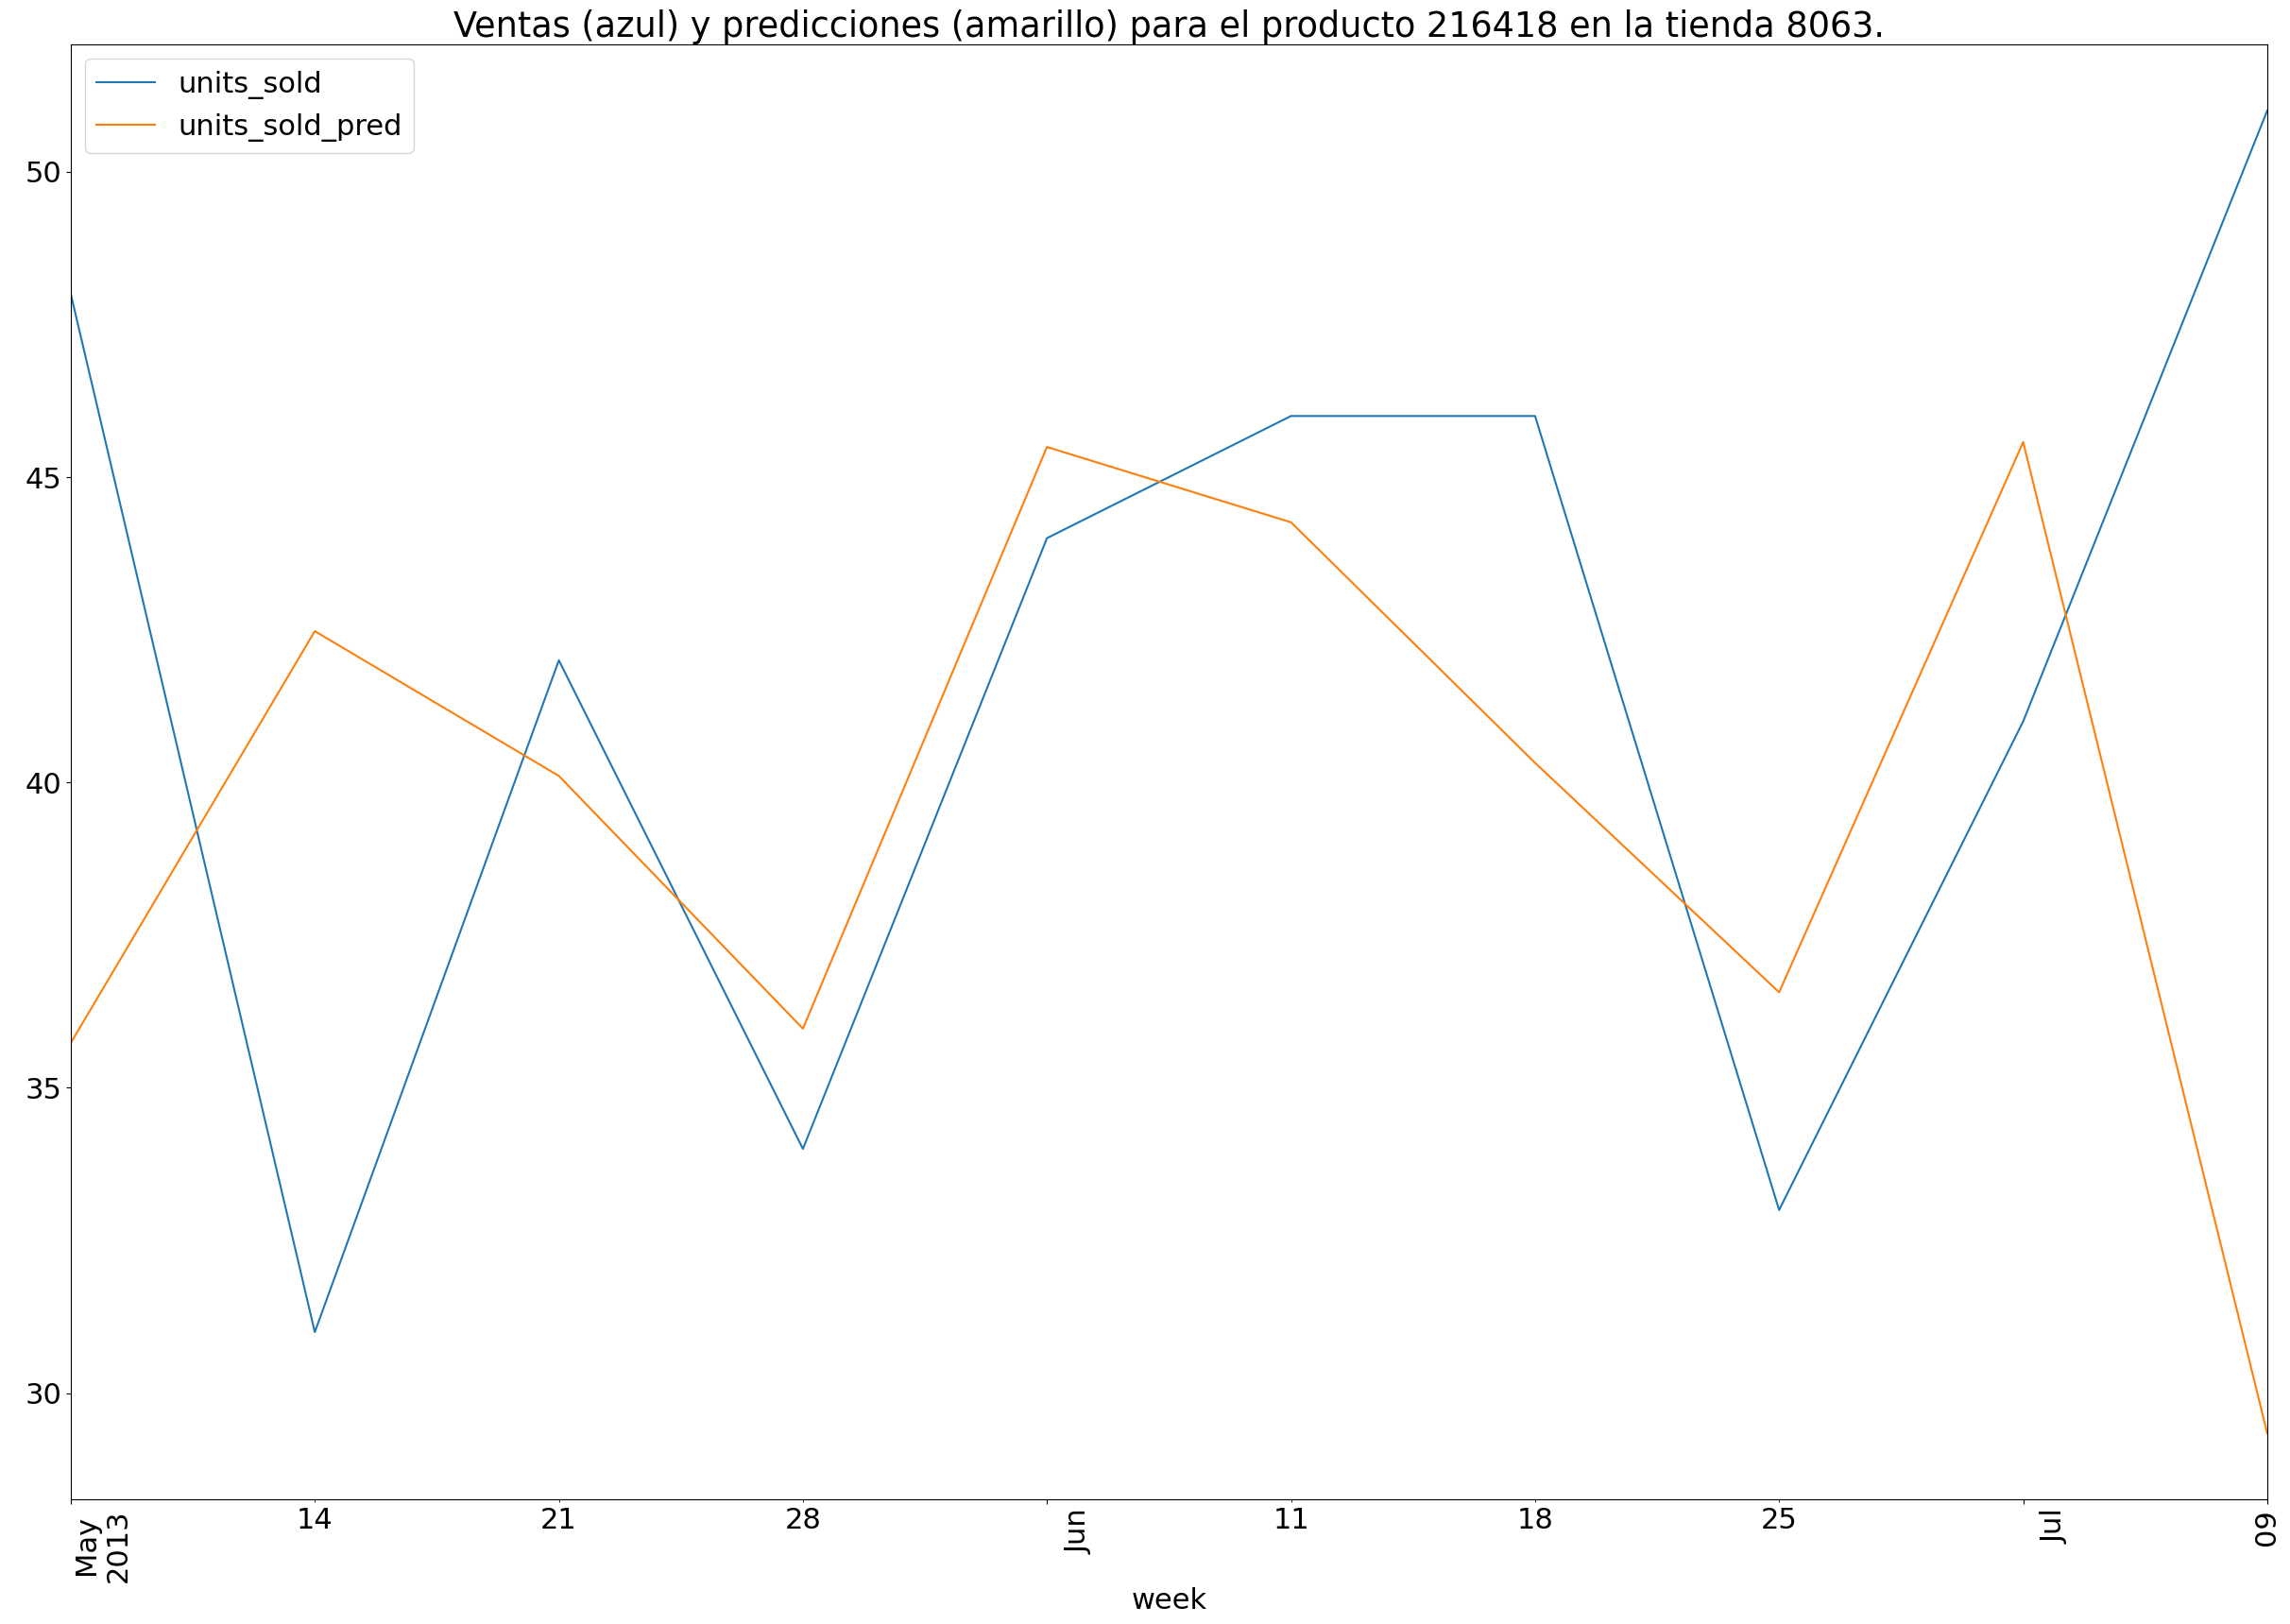

In [ ]:
# Respuesta

plot_sales_and_preds(df_test, list_sku_id[0], list_store_id[3])

<Figure size 640x480 with 0 Axes>

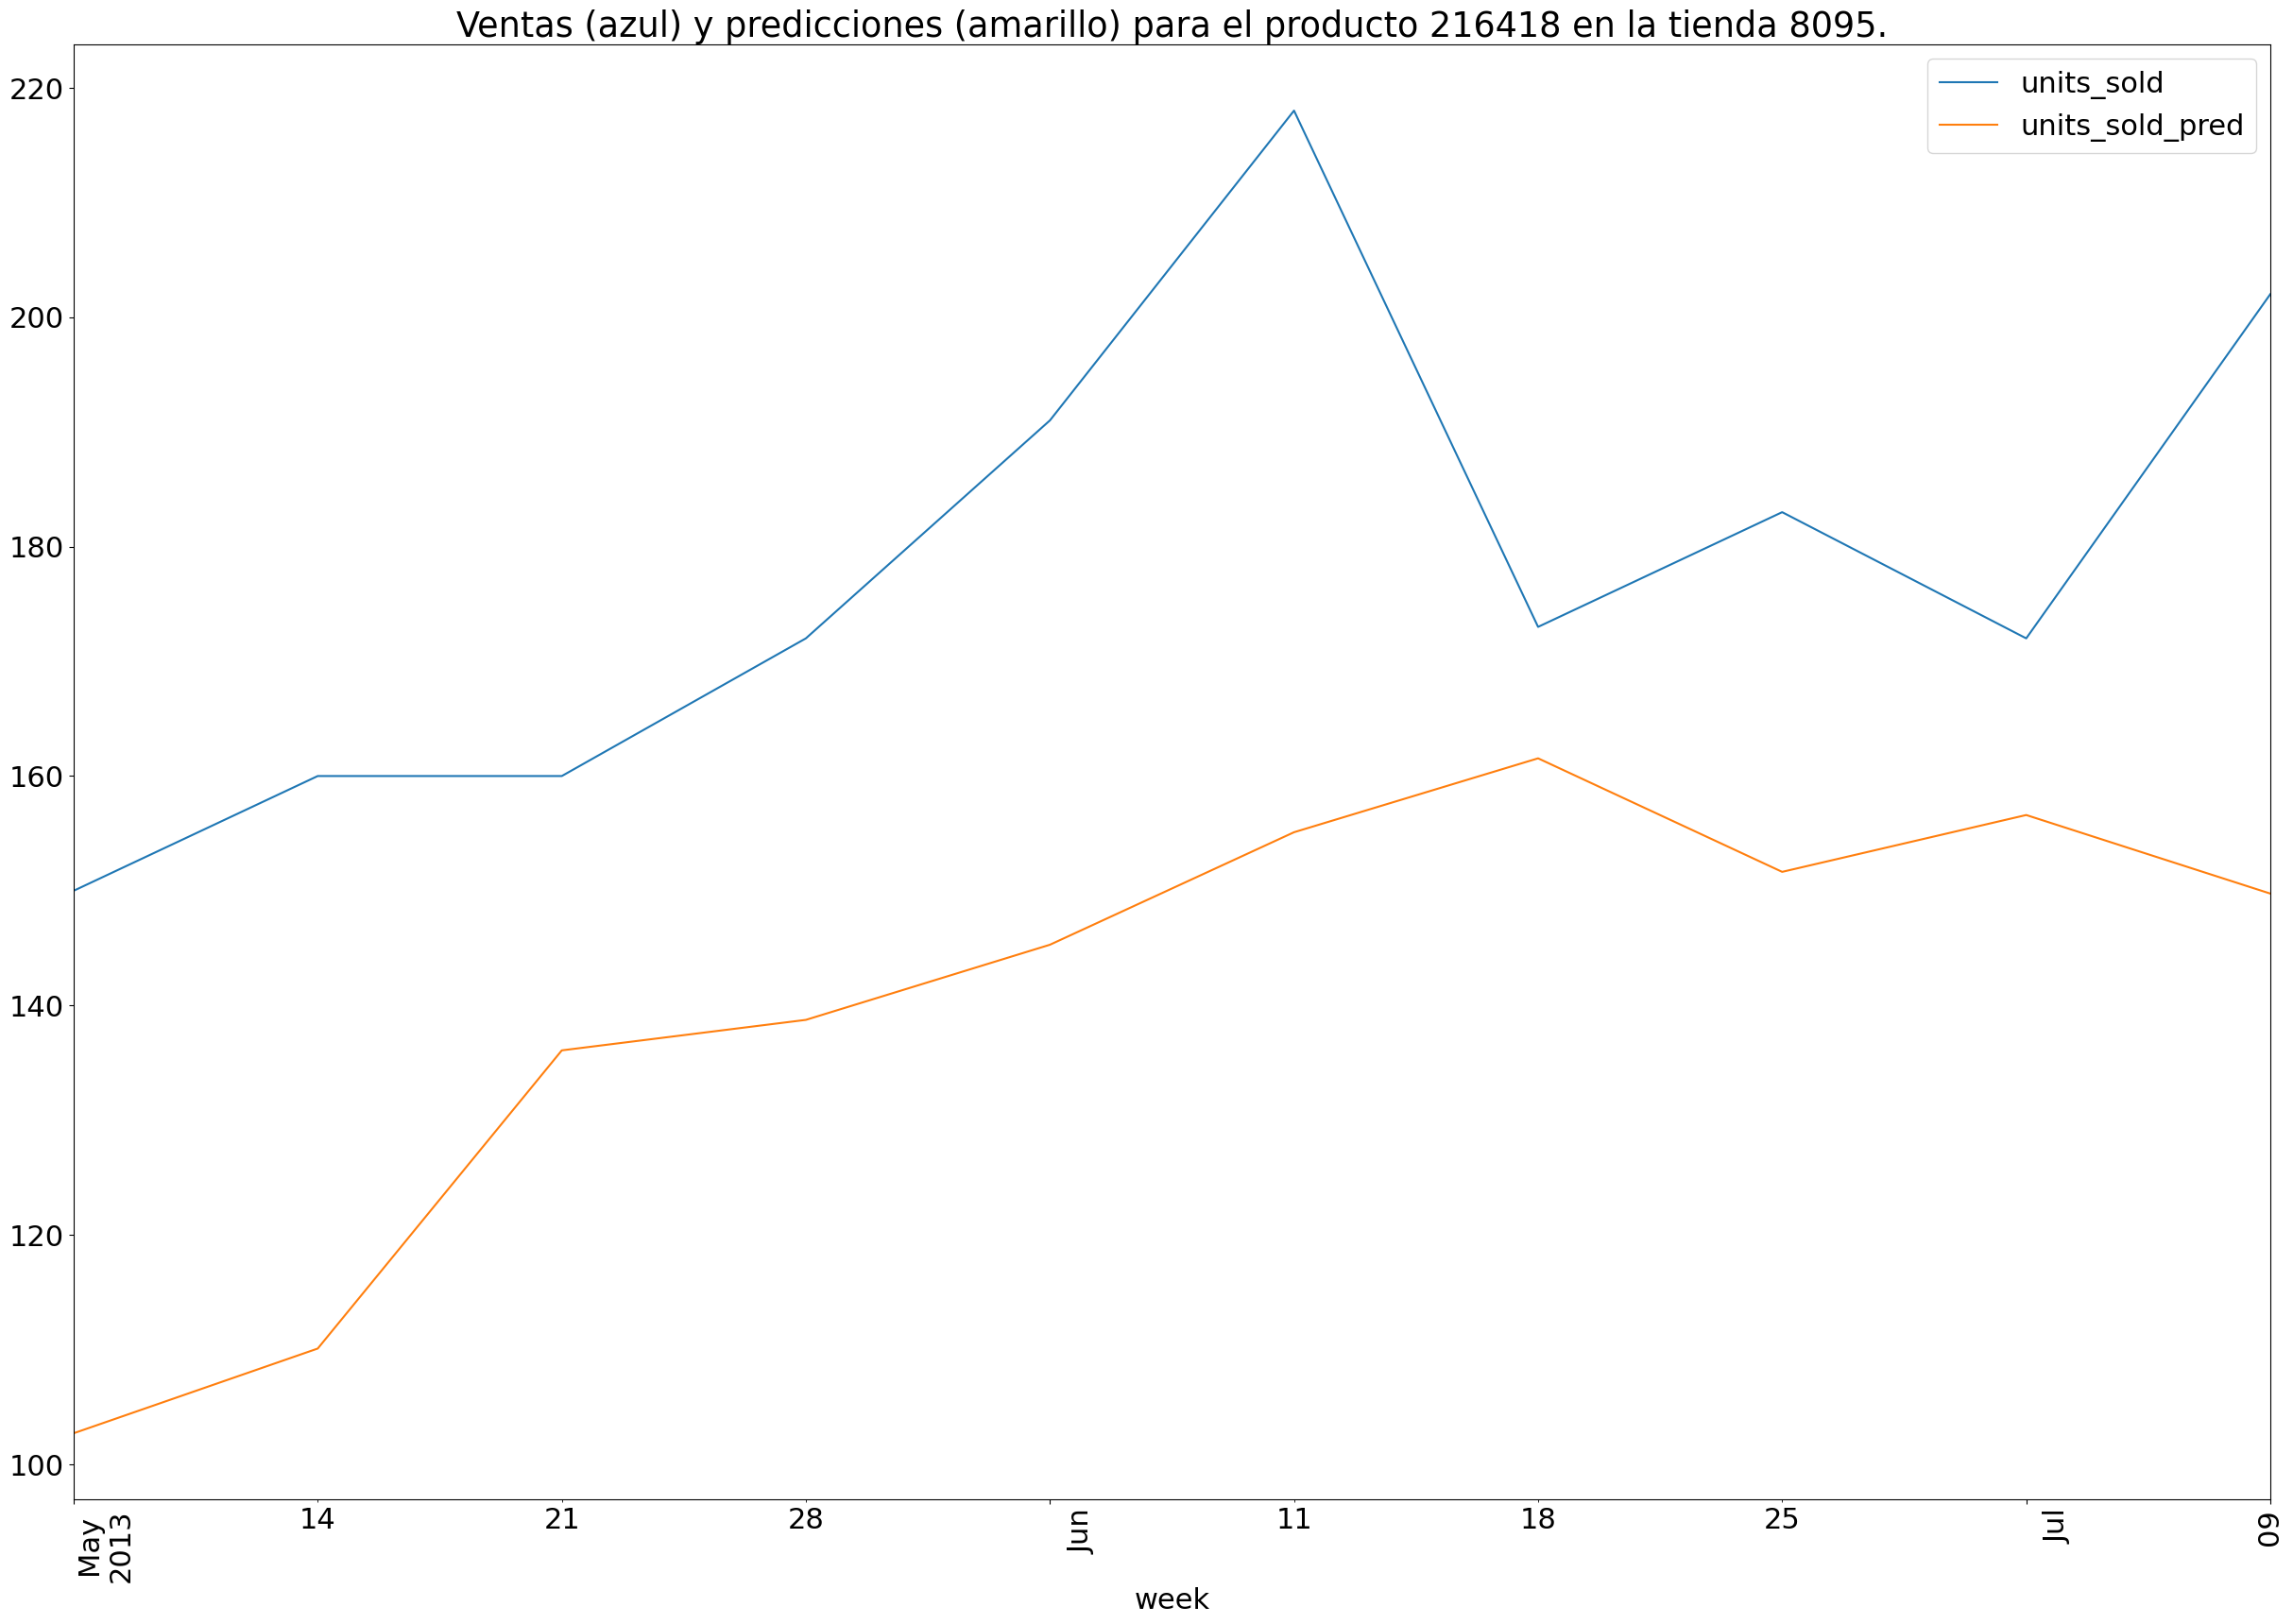

In [ ]:
plot_sales_and_preds(df_test, list_sku_id[0], list_store_id[1])